<a href="https://colab.research.google.com/github/siva-sankar-a/eva6-p1-s3/blob/main/EVA6_Session3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement

- The problem statement requires us to take in an MNIST hand written image and a normal digit as inputs to a neural network and predict the **MNIST digit label** and **the sum of the MNIST digit and the input digit**

### Inputs
  - _MNIST Image_
  - _A normal number_

### Outputs
  - _MNIST output label_
  - _Sum of MNIST number and input digit_


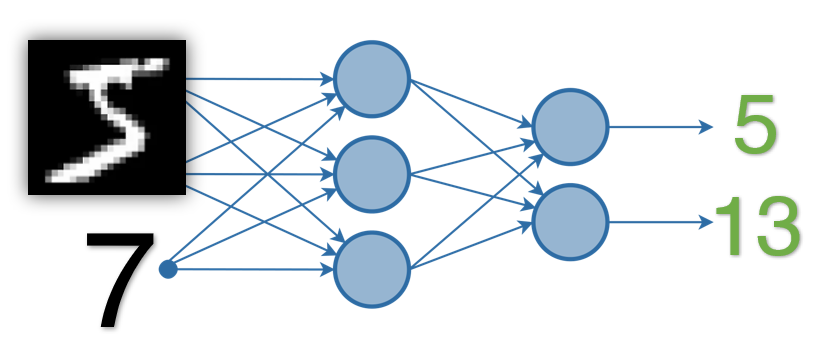

# Install necessary packages

In [1]:
!pip install torchsummary
!pip install torchviz
!pip install tqdm
!pip install graphviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=4f4f0965c9c221a06fa85274dec1cd4a68cbcacbeda9586e917efcc98b09d4e3
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [2]:
import pandas  as pd
import numpy as np
import glob, re

import os
import glob
import datetime
import matplotlib.pyplot as plt
import json

import torch
import torchvision
from torchsummary import summary 
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import torchvision.models as models

from sklearn.metrics import classification_report

from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau

from tqdm import tqdm

# Create custom  dataset

In [3]:
class Custom_MNIST(Dataset):
  def __init__(self, train=True):
    self.data_set = torchvision.datasets.MNIST(
        root='./data', train=train, download=True, 
        transform=transforms.Compose([transforms.ToTensor()
                                      ]))

  def __getitem__(self, index):
    sample, label = self.data_set[index]

    in_num = np.random.randint(0, 10)
    out_num = in_num + label
    return {'sample': sample, 
            'label': label, 
            'in_num': in_num, 
            'out_num': out_num}
  
  def __len__(self):
    return len(self.data_set)

In [4]:
dataset = Custom_MNIST()

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
data_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=8, 
                                           shuffle=True)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 16

In [6]:
batch = next(iter(data_loader))

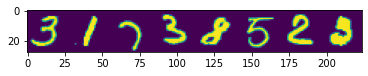

In [7]:
img = torch.hstack([i.squeeze() for i in batch['sample']]).cpu().numpy()
plt.imshow(img)

# Create the network

In [8]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False),
                                   nn.BatchNorm2d(8),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.BatchNorm2d(8),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, bias=False),
                                   nn.BatchNorm2d(16),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False),
                                   nn.BatchNorm2d(32),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.ReLU())

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # Embedding layers for the input and the output from GAP layer
        self.label_embedding = nn.Embedding(10, 19)
        self.in_num_embedding = nn.Embedding(10, 19)

        # MNIST digits classification head
        self.linear_out1 = nn.Linear(32, 10)
        

    def blocks(self, x, y):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        return x

    def forward(self, x, y=torch.tensor([1, 1])):
        x_gap = self.blocks(x, y)
        
        x_gap = x_gap.squeeze()

        # MNIST digits classification head
        x1 = self.linear_out1(x_gap)

        # Sum of digits classification head
        l1 = F.log_softmax(x1, dim=-1)

        # Select the winnning number
        l1 = l1.argmax(dim=1, keepdim=True)

        # Remove unwanted dimensions
        l1 = l1.squeeze()

        # Generate ebeddings
        y = self.in_num_embedding(y)
        x2 = self.label_embedding(l1)

        # Simply add them up
        # Improvement: Can try concat and downsampling later
        x2 = x2 + y

        return x1, x2

In [9]:
model = Net()
summary(model, input_size=(1, 28, 28), batch_size=2, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [2, 8, 28, 28]              72
       BatchNorm2d-2             [2, 8, 28, 28]              16
         MaxPool2d-3             [2, 8, 14, 14]               0
       BatchNorm2d-4             [2, 8, 14, 14]              16
              ReLU-5             [2, 8, 14, 14]               0
            Conv2d-6            [2, 16, 14, 14]           1,152
       BatchNorm2d-7            [2, 16, 14, 14]              32
         MaxPool2d-8              [2, 16, 7, 7]               0
              ReLU-9              [2, 16, 7, 7]               0
           Conv2d-10              [2, 32, 7, 7]           4,608
      BatchNorm2d-11              [2, 32, 7, 7]              64
        MaxPool2d-12              [2, 32, 3, 3]               0
             ReLU-13              [2, 32, 3, 3]               0
AdaptiveAvgPool2d-14              [2, 3

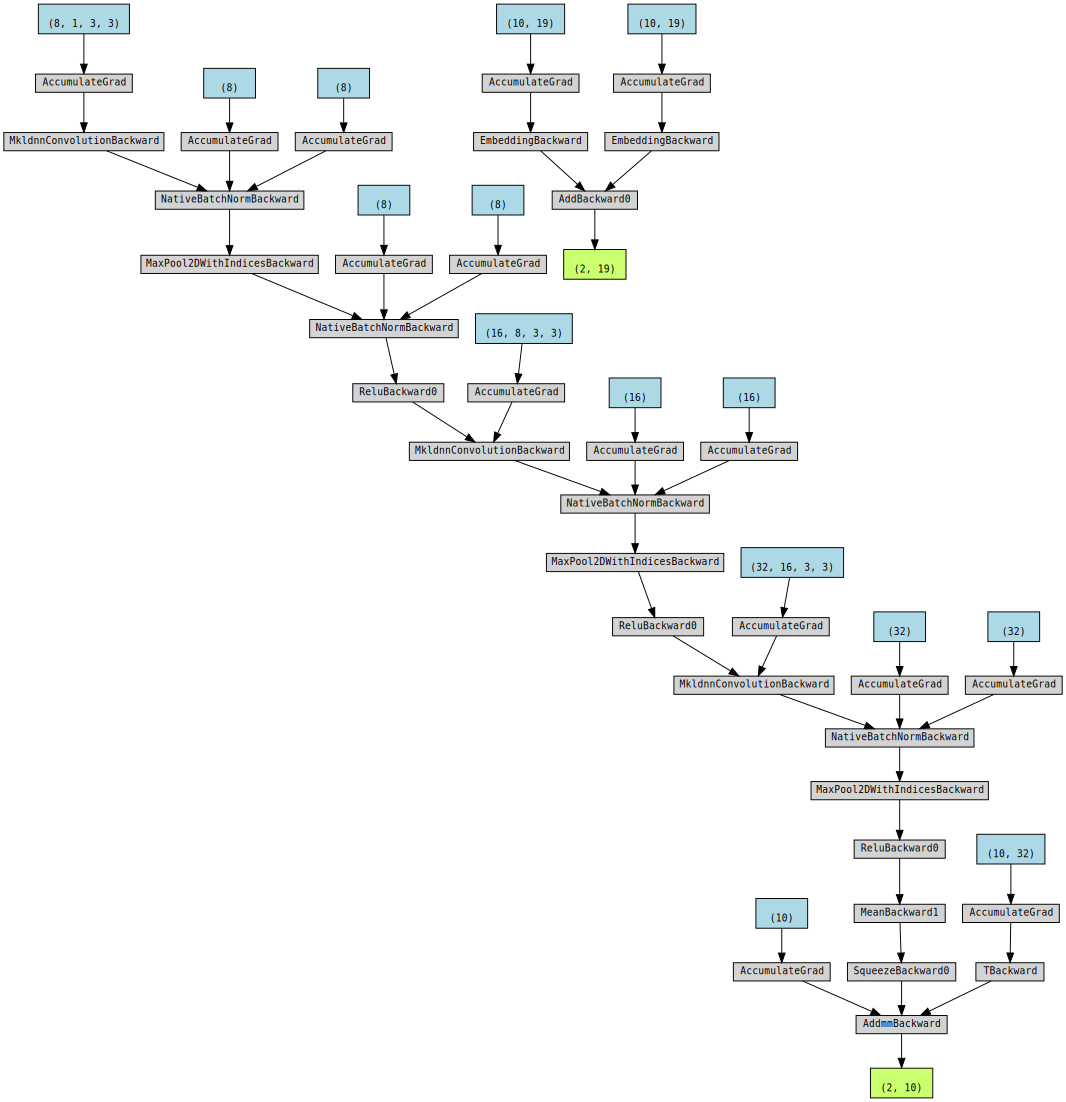

In [10]:
random_input = torch.randn(2, 1, 28, 28)
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph

# Training function

In [11]:
def train(model, device, train_loader, optimizer, epoch, logs, scheduler=None):

    model.train()
    train_loss = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)
    n_train_batches = train_len / train_loader.batch_size

    train_loss, acc_label, acc_out_num = 0, 0, 0

    y_label = []
    y_pred_label = []

    y_in_num = []
    
    y_out_num = []
    y_pred_out_num = []

    log = {}
    log['epoch'] = epoch
    log['batch_loss'] = []

    # class_weights = [8, 8.5, 8.6, 8.7, 8.8, 8.9, 10, 12.25, 14.5, 16, 14.5, 12.25, 10, 8.9, 8.8, 8.7, 8.6, 8.5, 8]
    # class_weights = torch.tensor(class_weights, device=device).float()

    for batch_idx, batch in enumerate(pbar):
        sample = batch['sample'].float()
        label = batch['label'].long()
        in_num = batch['in_num'].long()
        out_num = batch['out_num'].long()

        y_label.extend(label)
        y_in_num.extend(in_num)
        y_out_num.extend(out_num)

        # print(batch_input)
        # Move data to cpu/gpu based on input
        sample = sample.to(device)
        label = label.to(device)
        in_num = in_num.to(device)
        out_num = out_num.to(device)

        optimizer.zero_grad()

        # Forward pass
        out1, out2 = model(sample, in_num)

        # Loss computation
        bce1 = F.cross_entropy(out1, label, reduction='mean')
        # bce2 = F.cross_entropy(out2, out_num, weight=class_weights, reduction='mean')
        bce2 = F.cross_entropy(out2, out_num, reduction='mean')

        # print(bce1, bce2)
        batch_loss = bce1 + bce2
        train_loss += (batch_loss / n_train_batches).item()

        # Backward pass)
        batch_loss.backward()

        # Gradient descent
        optimizer.step()

        # Predictions
        output1 = F.log_softmax(out1, dim=-1)
        pred1 = output1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred_label.extend(pred1.detach().cpu().tolist())
        acc_label += (pred1.eq(label.view_as(pred1)).float().mean().item() / n_train_batches)

        output2 = F.log_softmax(out2, dim=-1)
        pred2 = output2.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred_out_num.extend(pred2.detach().cpu().tolist())
        acc_out_num += (pred2.eq(out_num.view_as(pred2)).float().mean().item() / n_train_batches)

        # Step scheduler if scheduler is present
        if scheduler:
            scheduler.step()

        # Logging - updating progress bar and summary writer
        pbar.set_description(desc= f'TRAIN : epoch={epoch} acc_l: {100 * acc_label:.2f} acc_o: {100 * acc_out_num:.2f} loss: {train_loss:.5f}')
        log['batch_loss'].append(batch_loss.item())

    print('\n')
    report_label = classification_report(y_label, y_pred_label, zero_division=0, output_dict=True)
    report_out_num = classification_report(y_out_num, y_pred_out_num, zero_division=0, output_dict=True)

    for item in report_label:
        print(f'{item:20s} : {report_label[item]}')

    for item in report_out_num:
        print(f'{item:20s} : {report_out_num[item]}')
    
    log['train_loss'] = train_loss
    log['report_label'] = report_label
    log['report_out_num'] = report_out_num

    logs['train'].append(log)
    return train_loss, (acc_label + acc_out_num) / 2

# Testing function

In [12]:
def test(model, device, test_loader, epoch, logs):

    model.eval()
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    n_test_batches = test_len / test_loader.batch_size

    test_loss, acc_label, acc_out_num = 0, 0, 0

    y_label = []
    y_pred_label = []

    y_in_num = []
    
    y_out_num = []
    y_pred_out_num = []

    log = {}
    log['epoch'] = epoch
    log['batch_loss'] = []

    # class_weights = [8, 8.5, 8.6, 8.7, 8.8, 8.9, 10, 12.25, 14.5, 16, 14.5, 12.25, 10, 8.9, 8.8, 8.7, 8.6, 8.5, 8]
    # class_weights = torch.tensor(class_weights, device=device).float()
    
    for batch_idx, batch in enumerate(pbar):
        sample = batch['sample'].float()
        label = batch['label'].long()
        in_num = batch['in_num'].long()
        out_num = batch['out_num'].long()

        y_label.extend(label)
        y_in_num.extend(in_num)
        y_out_num.extend(out_num)

        # print(batch_input)
        # Move data to cpu/gpu based on input
        sample = sample.to(device)
        label = label.to(device)
        in_num = in_num.to(device)
        out_num = out_num.to(device)

        # Forward pass
        out1, out2 = model(sample, in_num)

        # Loss computation
        bce1 = F.cross_entropy(out1, label, reduction='mean')
        # bce2 = F.cross_entropy(out2, out_num, weight=class_weights, reduction='mean')
        bce2 = F.cross_entropy(out2, out_num, reduction='mean')

        # print(bce1, bce2)
        batch_loss = bce1 + bce2
        test_loss += (batch_loss / n_test_batches).item()
        
        # Predictions
        output1 = F.log_softmax(out1, dim=-1)
        pred1 = output1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred_label.extend(pred1.detach().cpu().tolist())
        acc_label += (pred1.eq(label.view_as(pred1)).float().mean().item() / n_test_batches)

        output2 = F.log_softmax(out2, dim=-1)
        pred2 = output2.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred_out_num.extend(pred2.detach().cpu().tolist())
        acc_out_num += (pred2.eq(out_num.view_as(pred2)).float().mean().item() / n_test_batches)
        
        # Logging - updating progress bar and summary writer
        pbar.set_description(desc= f'TEST : epoch={epoch} acc_l: {100 * acc_label:.2f} acc_o: {100 * acc_out_num:.2f} loss: {test_loss:.5f}')
        log['batch_loss'].append(batch_loss.item())

    print('\n')
    report_label = classification_report(y_label, y_pred_label, zero_division=0, output_dict=True)
    report_out_num = classification_report(y_out_num, y_pred_out_num, zero_division=0, output_dict=True)

    for item in report_label:
        print(f'{item:20s} : {report_label[item]}')

    for item in report_out_num:
        print(f'{item:20s} : {report_out_num[item]}')
    
    log['test_loss'] = test_loss
    log['report_label'] = report_label
    log['report_out_num'] = report_out_num

    logs['test'].append(log)
    return test_loss, (acc_label + acc_out_num) / 2

# Training

## Startup

In [13]:
model = Net()
model = model.to(device)

In [16]:
tqdm._instances.clear()

## Train

In [15]:
experiment_name = 'EVA6_S3'
model_dir_suffix = '/content/drive/MyDrive/EVA6/S3/models'
log_file = f'/content/drive/MyDrive/EVA6/S3/logs/log_{experiment_name}.json'

lr = 1e-2
epochs = 30
momentum = 0.99

# optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=True)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=1500)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

best_test_accuracy = 0
best_test_loss = float('inf')
best_model_path = ''

logs = {}
logs['train'] = []
logs['test'] = []

sample_input_cpu = torch.randn(2, 1, 28, 28).to('cpu')

train_dataset = Custom_MNIST(train=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=32, 
                                           shuffle=True)
test_dataset = Custom_MNIST(train=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=32, 
                                           shuffle=True)

for epoch in range(0, epochs):
    
    train_loss, train_accuracy = train(model, device, train_dataloader, optimizer, epoch, logs, scheduler=None)
    test_loss, test_accuracy = test(model, device, test_dataloader, epoch, logs)
    
    if test_accuracy > best_test_accuracy:
        best_model_path = f'{model_dir_suffix}/acc_{test_accuracy:2.2f}_epoch_{epoch}.pth'
        
        model_cpu = model.to('cpu')
        model_cpu = torch.jit.trace(model_cpu, sample_input_cpu)
        torch.jit.save(model_cpu, best_model_path)
        
        best_test_accuracy = test_accuracy 
        best_test_loss = test_loss
        
        model = model.to(device)
    with open(log_file, 'w') as outfile:
        json.dump(logs, outfile)
    
    scheduler.step()

TRAIN : epoch=0 acc_l: 92.59 acc_o: 34.03 loss: 2.23697: 100%|██████████| 1875/1875 [00:34<00:00, 53.85it/s]


TEST : epoch=0 acc_l: 0.31 acc_o: 0.17 loss: 0.00539:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9300233255581473, 'recall': 0.9424278237379706, 'f1-score': 0.9361844863731655, 'support': 5923}
1                    : {'precision': 0.958005249343832, 'recall': 0.9744882824087808, 'f1-score': 0.9661764705882353, 'support': 6742}
2                    : {'precision': 0.9107498341074983, 'recall': 0.9214501510574018, 'f1-score': 0.91606874687135, 'support': 5958}
3                    : {'precision': 0.923391048676903, 'recall': 0.9220355570053825, 'f1-score': 0.9227128050273403, 'support': 6131}
4                    : {'precision': 0.9480864635010631, 'recall': 0.9159534406025334, 'f1-score': 0.9317429914678739, 'support': 5842}
5                    : {'precision': 0.888949572182778, 'recall': 0.9007563180225051, 'f1-score': 0.8948140003665018, 'support': 5421}
6                    : {'precision': 0.9448370970522324, 'recall': 0.9261574856370396, 'f1-score': 0.9354040447137129, 'support': 5918}
7                    : {'precision': 0.94578021623366

TEST : epoch=0 acc_l: 97.65 acc_o: 49.23 loss: 1.69091: 100%|██████████| 1875/1875 [00:24<00:00, 75.99it/s]




0                    : {'precision': 0.9980451395059534, 'recall': 0.9481681580280263, 'f1-score': 0.9724675324675324, 'support': 5923}
1                    : {'precision': 0.981302950628104, 'recall': 0.996440225452388, 'f1-score': 0.9888136591109803, 'support': 6742}
2                    : {'precision': 0.9933890048712596, 'recall': 0.9583752937227258, 'f1-score': 0.9755680847428669, 'support': 5958}
3                    : {'precision': 0.9790686354048354, 'recall': 0.984178763660088, 'f1-score': 0.9816170489669758, 'support': 6131}
4                    : {'precision': 0.9746450304259635, 'recall': 0.9869907565902089, 'f1-score': 0.9807790440551114, 'support': 5842}
5                    : {'precision': 0.9647101188332733, 'recall': 0.9883785279468733, 'f1-score': 0.9764009111617312, 'support': 5421}
6                    : {'precision': 0.9384468186892043, 'recall': 0.9944237918215614, 'f1-score': 0.9656247436212979, 'support': 5918}
7                    : {'precision': 0.9896856581

TRAIN : epoch=1 acc_l: 97.75 acc_o: 47.78 loss: 1.60028: 100%|██████████| 1875/1875 [00:34<00:00, 53.91it/s]


TEST : epoch=1 acc_l: 0.74 acc_o: 0.45 loss: 0.01091:   0%|          | 9/1875 [00:00<00:22, 83.00it/s]

0                    : {'precision': 0.984427894380501, 'recall': 0.9819348303224718, 'f1-score': 0.983179781928831, 'support': 5923}
1                    : {'precision': 0.9860864416814683, 'recall': 0.9881340848412934, 'f1-score': 0.9871092013631649, 'support': 6742}
2                    : {'precision': 0.9759946281685412, 'recall': 0.9758308157099698, 'f1-score': 0.975912715065044, 'support': 5958}
3                    : {'precision': 0.9813176007866273, 'recall': 0.9766759093133257, 'f1-score': 0.9789912531676612, 'support': 6131}
4                    : {'precision': 0.9814305364511692, 'recall': 0.9770626497774735, 'f1-score': 0.979241722422371, 'support': 5842}
5                    : {'precision': 0.971976401179941, 'recall': 0.9725142962553035, 'f1-score': 0.9722452743199631, 'support': 5421}
6                    : {'precision': 0.9799798115746972, 'recall': 0.9842852314971274, 'f1-score': 0.9821278030686226, 'support': 5918}
7                    : {'precision': 0.97606214331008

TEST : epoch=1 acc_l: 98.70 acc_o: 60.41 loss: 1.47870: 100%|██████████| 1875/1875 [00:25<00:00, 74.51it/s]




0                    : {'precision': 0.9856235372785022, 'recall': 0.9954414992402498, 'f1-score': 0.9905081898362031, 'support': 5923}
1                    : {'precision': 0.991566799822459, 'recall': 0.9940670424206467, 'f1-score': 0.9928153470113326, 'support': 6742}
2                    : {'precision': 0.9880551816958277, 'recall': 0.9857334676065794, 'f1-score': 0.9868929591665266, 'support': 5958}
3                    : {'precision': 0.9924651924651925, 'recall': 0.9882564018920241, 'f1-score': 0.9903563255966001, 'support': 6131}
4                    : {'precision': 0.9916854321843063, 'recall': 0.9799726121191373, 'f1-score': 0.9857942315970728, 'support': 5842}
5                    : {'precision': 0.9878026242838662, 'recall': 0.9859804464121011, 'f1-score': 0.986890694239291, 'support': 5421}
6                    : {'precision': 0.9915469146238377, 'recall': 0.9910442717134167, 'f1-score': 0.9912955294515339, 'support': 5918}
7                    : {'precision': 0.992366412

TRAIN : epoch=2 acc_l: 98.38 acc_o: 51.15 loss: 1.45090: 100%|██████████| 1875/1875 [00:35<00:00, 53.00it/s]


TEST : epoch=2 acc_l: 0.31 acc_o: 0.15 loss: 0.00479:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9897150564828865, 'recall': 0.991051831841972, 'f1-score': 0.9903829930825038, 'support': 5923}
1                    : {'precision': 0.9912527798369163, 'recall': 0.9916938593889054, 'f1-score': 0.9914732705568325, 'support': 6742}
2                    : {'precision': 0.9809077206498074, 'recall': 0.9830480026854649, 'f1-score': 0.9819766954480676, 'support': 5958}
3                    : {'precision': 0.9857610474631752, 'recall': 0.9823846028380362, 'f1-score': 0.9840699289273752, 'support': 6131}
4                    : {'precision': 0.9854177388917481, 'recall': 0.983224922971585, 'f1-score': 0.9843201096735498, 'support': 5842}
5                    : {'precision': 0.9788252623826184, 'recall': 0.9806308799114555, 'f1-score': 0.9797272392185773, 'support': 5421}
6                    : {'precision': 0.9866396076441738, 'recall': 0.9858060155457925, 'f1-score': 0.9862226354492435, 'support': 5918}
7                    : {'precision': 0.98345529748

TEST : epoch=2 acc_l: 98.41 acc_o: 53.31 loss: 1.41227: 100%|██████████| 1875/1875 [00:25<00:00, 73.68it/s]


TRAIN : epoch=3 acc_l: 0.16 acc_o: 0.10 loss: 0.00203:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9969024264326277, 'recall': 0.9780516630086105, 'f1-score': 0.9873870802795294, 'support': 5923}
1                    : {'precision': 0.9908635425876805, 'recall': 0.9973301690892911, 'f1-score': 0.994086339444116, 'support': 6742}
2                    : {'precision': 0.9678577255669767, 'recall': 0.995636119503189, 'f1-score': 0.9815504260776041, 'support': 5958}
3                    : {'precision': 0.9962052466589671, 'recall': 0.9848311857771979, 'f1-score': 0.9904855643044619, 'support': 6131}
4                    : {'precision': 0.9604417339706609, 'recall': 0.9974323861691201, 'f1-score': 0.9785876228062809, 'support': 5842}
5                    : {'precision': 0.989979588049731, 'recall': 0.9841357683084302, 'f1-score': 0.9870490286771509, 'support': 5421}
6                    : {'precision': 0.9665244502789629, 'recall': 0.9952686718485975, 'f1-score': 0.9806859806859807, 'support': 5918}
7                    : {'precision': 0.997205785667

TRAIN : epoch=3 acc_l: 98.41 acc_o: 57.48 loss: 1.37443: 100%|██████████| 1875/1875 [00:35<00:00, 52.75it/s]


TEST : epoch=3 acc_l: 0.31 acc_o: 0.19 loss: 0.00436:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9915497718438397, 'recall': 0.9905453317575553, 'f1-score': 0.9910472972972972, 'support': 5923}
1                    : {'precision': 0.990386037568407, 'recall': 0.9931770987837437, 'f1-score': 0.9917796045323263, 'support': 6742}
2                    : {'precision': 0.9820349227669577, 'recall': 0.9817052702249077, 'f1-score': 0.9818700688265906, 'support': 5958}
3                    : {'precision': 0.9841425535393167, 'recall': 0.9818952862502038, 'f1-score': 0.9830176355323317, 'support': 6131}
4                    : {'precision': 0.9854252400548696, 'recall': 0.983738445737761, 'f1-score': 0.9845811204385815, 'support': 5842}
5                    : {'precision': 0.9793434157137587, 'recall': 0.9795240730492529, 'f1-score': 0.9794337360509084, 'support': 5421}
6                    : {'precision': 0.9880168776371308, 'recall': 0.9891855356539372, 'f1-score': 0.9886008612682597, 'support': 5918}
7                    : {'precision': 0.98140495867

TEST : epoch=3 acc_l: 99.07 acc_o: 58.59 loss: 1.30766: 100%|██████████| 1875/1875 [00:25<00:00, 72.29it/s]


TRAIN : epoch=4 acc_l: 0.11 acc_o: 0.07 loss: 0.00132:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.996776382762131, 'recall': 0.9918959986493331, 'f1-score': 0.9943302022509943, 'support': 5923}
1                    : {'precision': 0.9985023214018272, 'recall': 0.9888757045387125, 'f1-score': 0.9936656978910501, 'support': 6742}
2                    : {'precision': 0.9876625541847283, 'recall': 0.9942933870426317, 'f1-score': 0.9909668785547006, 'support': 5958}
3                    : {'precision': 0.996225795864785, 'recall': 0.9902136682433534, 'f1-score': 0.9932106339468302, 'support': 6131}
4                    : {'precision': 0.9929541158274617, 'recall': 0.9890448476549127, 'f1-score': 0.9909956264471315, 'support': 5842}
5                    : {'precision': 0.9907766094816455, 'recall': 0.9907766094816455, 'f1-score': 0.9907766094816455, 'support': 5421}
6                    : {'precision': 0.9848156182212582, 'recall': 0.9972963839134843, 'f1-score': 0.9910167072454035, 'support': 5918}
7                    : {'precision': 0.99325626204

TRAIN : epoch=4 acc_l: 98.75 acc_o: 60.43 loss: 1.29944: 100%|██████████| 1875/1875 [00:36<00:00, 52.03it/s]


TEST : epoch=4 acc_l: 0.69 acc_o: 0.43 loss: 0.00864:   0%|          | 8/1875 [00:00<00:26, 70.80it/s]

0                    : {'precision': 0.9932398174750718, 'recall': 0.9922336653722775, 'f1-score': 0.9927364864864865, 'support': 5923}
1                    : {'precision': 0.9915643036850673, 'recall': 0.993770394541679, 'f1-score': 0.9926661234165494, 'support': 6742}
2                    : {'precision': 0.9869083585095669, 'recall': 0.9869083585095669, 'f1-score': 0.9869083585095669, 'support': 5958}
3                    : {'precision': 0.9914935383608703, 'recall': 0.988582612950579, 'f1-score': 0.9900359359686377, 'support': 6131}
4                    : {'precision': 0.9874699622382423, 'recall': 0.9847654912701129, 'f1-score': 0.9861158724717175, 'support': 5842}
5                    : {'precision': 0.9841620626151013, 'recall': 0.985795978601734, 'f1-score': 0.9849783430098608, 'support': 5421}
6                    : {'precision': 0.9888607594936709, 'recall': 0.9900304156809733, 'f1-score': 0.9894452419150553, 'support': 5918}
7                    : {'precision': 0.985518777848

TEST : epoch=4 acc_l: 98.43 acc_o: 60.50 loss: 1.29675: 100%|██████████| 1875/1875 [00:26<00:00, 71.18it/s]


TRAIN : epoch=5 acc_l: 0.05 acc_o: 0.03 loss: 0.00069:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9950814111261872, 'recall': 0.9905453317575553, 'f1-score': 0.9928081902022168, 'support': 5923}
1                    : {'precision': 0.98376480912681, 'recall': 0.9976268169682587, 'f1-score': 0.9906473230723912, 'support': 6742}
2                    : {'precision': 0.9818030050083473, 'recall': 0.9870762000671366, 'f1-score': 0.9844325410110478, 'support': 5958}
3                    : {'precision': 0.9986743993371997, 'recall': 0.983037024955146, 'f1-score': 0.9907940161104719, 'support': 6131}
4                    : {'precision': 0.9436893203883495, 'recall': 0.9982882574460801, 'f1-score': 0.9702212610214607, 'support': 5842}
5                    : {'precision': 0.9979249198264478, 'recall': 0.975834716841911, 'f1-score': 0.9867562022010818, 'support': 5421}
6                    : {'precision': 0.9824737105658488, 'recall': 0.9945927678269686, 'f1-score': 0.9884960953900412, 'support': 5918}
7                    : {'precision': 0.9943438914027

TRAIN : epoch=5 acc_l: 98.85 acc_o: 63.99 loss: 1.24939: 100%|██████████| 1875/1875 [00:36<00:00, 51.65it/s]


TEST : epoch=5 acc_l: 0.32 acc_o: 0.23 loss: 0.00366:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9922506738544474, 'recall': 0.9944284990714165, 'f1-score': 0.9933383927818534, 'support': 5923}
1                    : {'precision': 0.9925969795676636, 'recall': 0.9943636902996144, 'f1-score': 0.9934795494961469, 'support': 6742}
2                    : {'precision': 0.9874097700184656, 'recall': 0.9872440416247062, 'f1-score': 0.9873268988669743, 'support': 5958}
3                    : {'precision': 0.9916693890885332, 'recall': 0.9902136682433534, 'f1-score': 0.9909409940422754, 'support': 6131}
4                    : {'precision': 0.986981843096951, 'recall': 0.9863060595686409, 'f1-score': 0.9866438356164383, 'support': 5842}
5                    : {'precision': 0.9870753323485968, 'recall': 0.9861649142224682, 'f1-score': 0.9866199132601274, 'support': 5421}
6                    : {'precision': 0.990537343697195, 'recall': 0.990537343697195, 'f1-score': 0.990537343697195, 'support': 5918}
7                    : {'precision': 0.9885149146594

TEST : epoch=5 acc_l: 99.17 acc_o: 64.98 loss: 1.20823: 100%|██████████| 1875/1875 [00:26<00:00, 70.46it/s]




0                    : {'precision': 0.9954453441295547, 'recall': 0.996285666047611, 'f1-score': 0.9958653278204371, 'support': 5923}
1                    : {'precision': 0.9949592290585619, 'recall': 0.9954019578760012, 'f1-score': 0.9951805442277749, 'support': 6742}
2                    : {'precision': 0.9870194707938093, 'recall': 0.9954682779456193, 'f1-score': 0.9912258711456505, 'support': 5958}
3                    : {'precision': 0.9902676399026764, 'recall': 0.9957592562387865, 'f1-score': 0.9930058555627846, 'support': 6131}
4                    : {'precision': 0.9987749387469373, 'recall': 0.9768914755220814, 'f1-score': 0.9877120110764971, 'support': 5842}
5                    : {'precision': 0.9940564635958395, 'recall': 0.9872717210846708, 'f1-score': 0.9906524757056918, 'support': 5421}
6                    : {'precision': 0.9967796610169491, 'recall': 0.9937478877999324, 'f1-score': 0.9952614655610087, 'support': 5918}
7                    : {'precision': 0.99093655

TRAIN : epoch=6 acc_l: 98.93 acc_o: 66.23 loss: 1.20629: 100%|██████████| 1875/1875 [00:36<00:00, 51.35it/s]


TEST : epoch=6 acc_l: 0.27 acc_o: 0.18 loss: 0.00312:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9925738396624473, 'recall': 0.9929089988181665, 'f1-score': 0.9927413909520595, 'support': 5923}
1                    : {'precision': 0.9930329083901571, 'recall': 0.9936220706021952, 'f1-score': 0.9933274021352314, 'support': 6742}
2                    : {'precision': 0.9882609424786182, 'recall': 0.9890902987579725, 'f1-score': 0.9886754466907138, 'support': 5958}
3                    : {'precision': 0.9910145401078255, 'recall': 0.9893981405969663, 'f1-score': 0.990205680705191, 'support': 6131}
4                    : {'precision': 0.9910790873220107, 'recall': 0.9888736733995207, 'f1-score': 0.9899751520863679, 'support': 5842}
5                    : {'precision': 0.9861776631035754, 'recall': 0.9870872532743037, 'f1-score': 0.9866322485479857, 'support': 5421}
6                    : {'precision': 0.9915526271329617, 'recall': 0.9917201757350457, 'f1-score': 0.9916363943566783, 'support': 5918}
7                    : {'precision': 0.9880630272

TEST : epoch=6 acc_l: 99.25 acc_o: 69.23 loss: 1.16885: 100%|██████████| 1875/1875 [00:27<00:00, 69.17it/s]




0                    : {'precision': 0.9932761808707345, 'recall': 0.9976363329393888, 'f1-score': 0.9954514824797843, 'support': 5923}
1                    : {'precision': 0.9927675276752768, 'recall': 0.9976268169682587, 'f1-score': 0.9951912406599098, 'support': 6742}
2                    : {'precision': 0.9946353730092204, 'recall': 0.9958039610607586, 'f1-score': 0.9952193239956386, 'support': 5958}
3                    : {'precision': 0.9980308500164096, 'recall': 0.9920078290654053, 'f1-score': 0.9950102249488751, 'support': 6131}
4                    : {'precision': 0.9977547495682211, 'recall': 0.9888736733995207, 'f1-score': 0.9932943603851444, 'support': 5842}
5                    : {'precision': 0.99094771845557, 'recall': 0.9894853348090759, 'f1-score': 0.9902159867085103, 'support': 5421}
6                    : {'precision': 0.9751071546323772, 'recall': 0.9994930719837783, 'f1-score': 0.9871495327102804, 'support': 5918}
7                    : {'precision': 0.994726749

TRAIN : epoch=7 acc_l: 98.88 acc_o: 68.67 loss: 1.17976: 100%|██████████| 1875/1875 [00:36<00:00, 51.10it/s]


TEST : epoch=7 acc_l: 0.32 acc_o: 0.19 loss: 0.00405:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9920755353228797, 'recall': 0.9934154989025832, 'f1-score': 0.9927450649569766, 'support': 5923}
1                    : {'precision': 0.9931912374185908, 'recall': 0.9952536339365173, 'f1-score': 0.9942213661283152, 'support': 6742}
2                    : {'precision': 0.9862692565304756, 'recall': 0.9885867740852635, 'f1-score': 0.9874266554903603, 'support': 5958}
3                    : {'precision': 0.9910013089005235, 'recall': 0.9879301908334692, 'f1-score': 0.9894633668218574, 'support': 6131}
4                    : {'precision': 0.9903829641078482, 'recall': 0.9871619308456008, 'f1-score': 0.9887698242606087, 'support': 5842}
5                    : {'precision': 0.9850553505535056, 'recall': 0.9848736395498986, 'f1-score': 0.9849644866709714, 'support': 5421}
6                    : {'precision': 0.9900337837837838, 'recall': 0.9903683676917878, 'f1-score': 0.9902010474742355, 'support': 5918}
7                    : {'precision': 0.988701464

TEST : epoch=7 acc_l: 99.23 acc_o: 64.00 loss: 1.14380: 100%|██████████| 1875/1875 [00:27<00:00, 68.39it/s]


  0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9937856902922405, 'recall': 0.9989869998311667, 'f1-score': 0.9963795571272207, 'support': 5923}
1                    : {'precision': 0.9959899004901233, 'recall': 0.994660338178582, 'f1-score': 0.9953246753246754, 'support': 6742}
2                    : {'precision': 0.9858897742363878, 'recall': 0.9968110104061766, 'f1-score': 0.9913203138040394, 'support': 5958}
3                    : {'precision': 0.9845534995977474, 'recall': 0.9980427336486707, 'f1-score': 0.9912522274420864, 'support': 6131}
4                    : {'precision': 0.9891341256366724, 'recall': 0.9972612119137282, 'f1-score': 0.9931810433003752, 'support': 5842}
5                    : {'precision': 0.9966323666978485, 'recall': 0.9826600258254935, 'f1-score': 0.9895968790637192, 'support': 5421}
6                    : {'precision': 0.9974554707379135, 'recall': 0.9935789117945252, 'f1-score': 0.9955134174214849, 'support': 5918}
7                    : {'precision': 0.9888994608

TRAIN : epoch=8 acc_l: 99.10 acc_o: 69.70 loss: 1.13818: 100%|██████████| 1875/1875 [00:37<00:00, 49.97it/s]


TEST : epoch=8 acc_l: 0.27 acc_o: 0.21 loss: 0.00268:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9952702702702703, 'recall': 0.994766165794361, 'f1-score': 0.995018154183906, 'support': 5923}
1                    : {'precision': 0.9943661971830986, 'recall': 0.9948086621180658, 'f1-score': 0.9945873804404242, 'support': 6742}
2                    : {'precision': 0.9907749077490775, 'recall': 0.9914400805639476, 'f1-score': 0.9911073825503356, 'support': 5958}
3                    : {'precision': 0.9929853181076672, 'recall': 0.9928233567117926, 'f1-score': 0.9929043308049914, 'support': 6131}
4                    : {'precision': 0.9912626349151962, 'recall': 0.9904142416980486, 'f1-score': 0.9908382567000599, 'support': 5842}
5                    : {'precision': 0.9902177925433739, 'recall': 0.9896698026194429, 'f1-score': 0.9899437217455485, 'support': 5421}
6                    : {'precision': 0.9932421017063693, 'recall': 0.993409935789118, 'f1-score': 0.9933260116583593, 'support': 5918}
7                    : {'precision': 0.987898089171

TEST : epoch=8 acc_l: 99.14 acc_o: 69.01 loss: 1.11556: 100%|██████████| 1875/1875 [00:27<00:00, 67.82it/s]


  0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9929530201342281, 'recall': 0.9991558331926389, 'f1-score': 0.9960447698392663, 'support': 5923}
1                    : {'precision': 0.9987993396368002, 'recall': 0.9870958172649066, 'f1-score': 0.9929130921298023, 'support': 6742}
2                    : {'precision': 0.9701760104302477, 'recall': 0.9991607922121517, 'f1-score': 0.984455101703324, 'support': 5958}
3                    : {'precision': 0.9967245332459875, 'recall': 0.9926602511825151, 'f1-score': 0.994688240581842, 'support': 6131}
4                    : {'precision': 0.9982590529247911, 'recall': 0.9815131804176652, 'f1-score': 0.9898152943207319, 'support': 5842}
5                    : {'precision': 0.9981371087928465, 'recall': 0.9883785279468733, 'f1-score': 0.9932338492909444, 'support': 5421}
6                    : {'precision': 0.9926025554808339, 'recall': 0.9976343359242987, 'f1-score': 0.9951120849485926, 'support': 5918}
7                    : {'precision': 0.99691508361

TRAIN : epoch=9 acc_l: 99.13 acc_o: 73.28 loss: 1.11227: 100%|██████████| 1875/1875 [00:38<00:00, 49.21it/s]


TEST : epoch=9 acc_l: 0.32 acc_o: 0.24 loss: 0.00327:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9927572848239852, 'recall': 0.9951038325173054, 'f1-score': 0.993929173693086, 'support': 5923}
1                    : {'precision': 0.9934805156319455, 'recall': 0.9945120142390982, 'f1-score': 0.9939959973315543, 'support': 6742}
2                    : {'precision': 0.989256337082424, 'recall': 0.9890902987579725, 'f1-score': 0.9891733109525808, 'support': 5958}
3                    : {'precision': 0.9931551499348109, 'recall': 0.9939650954167346, 'f1-score': 0.9935599576098475, 'support': 6131}
4                    : {'precision': 0.9905757368060315, 'recall': 0.9895583704210886, 'f1-score': 0.9900667922589484, 'support': 5842}
5                    : {'precision': 0.9916958848496032, 'recall': 0.9913300129127467, 'f1-score': 0.9915129151291513, 'support': 5421}
6                    : {'precision': 0.993573482157957, 'recall': 0.992734031767489, 'f1-score': 0.9931535795790719, 'support': 5918}
7                    : {'precision': 0.9910571702331

TEST : epoch=9 acc_l: 99.20 acc_o: 73.61 loss: 1.09934: 100%|██████████| 1875/1875 [00:28<00:00, 66.57it/s]




0                    : {'precision': 0.998465996250213, 'recall': 0.9890258315043052, 'f1-score': 0.9937234944868533, 'support': 5923}
1                    : {'precision': 0.9833673767143274, 'recall': 0.9997033521210323, 'f1-score': 0.9914680788467197, 'support': 6742}
2                    : {'precision': 0.9886892880904857, 'recall': 0.9976502181940249, 'f1-score': 0.9931495405179617, 'support': 5958}
3                    : {'precision': 0.9991747813170491, 'recall': 0.987440874245637, 'f1-score': 0.9932731747333882, 'support': 6131}
4                    : {'precision': 0.9967269595176572, 'recall': 0.9904142416980486, 'f1-score': 0.9935605735382502, 'support': 5842}
5                    : {'precision': 0.9864815491413957, 'recall': 0.9961261759822911, 'f1-score': 0.9912804038549794, 'support': 5421}
6                    : {'precision': 0.9910999160369437, 'recall': 0.9972963839134843, 'f1-score': 0.994188494904405, 'support': 5918}
7                    : {'precision': 0.9966194462

TRAIN : epoch=10 acc_l: 99.56 acc_o: 81.00 loss: 1.06512: 100%|██████████| 1875/1875 [00:38<00:00, 48.74it/s]


TEST : epoch=10 acc_l: 0.59 acc_o: 0.48 loss: 0.00601:   0%|          | 7/1875 [00:00<00:27, 67.86it/s]

0                    : {'precision': 0.9972991222147198, 'recall': 0.9974674995779166, 'f1-score': 0.9973833037899891, 'support': 5923}
1                    : {'precision': 0.9958549222797928, 'recall': 0.9977751409077426, 'f1-score': 0.9968141068385568, 'support': 6742}
2                    : {'precision': 0.9963087248322148, 'recall': 0.9966431688486069, 'f1-score': 0.9964759187783185, 'support': 5958}
3                    : {'precision': 0.9977112963871179, 'recall': 0.9954330451802316, 'f1-score': 0.9965708687132592, 'support': 6131}
4                    : {'precision': 0.9960602946214457, 'recall': 0.9953782951044163, 'f1-score': 0.9957191780821919, 'support': 5842}
5                    : {'precision': 0.994103556292611, 'recall': 0.9952038369304557, 'f1-score': 0.9946533923303835, 'support': 5421}
6                    : {'precision': 0.9971264367816092, 'recall': 0.9967894558972626, 'f1-score': 0.9969579178637824, 'support': 5918}
7                    : {'precision': 0.9948971455

TEST : epoch=10 acc_l: 99.73 acc_o: 81.61 loss: 1.04828: 100%|██████████| 1875/1875 [00:28<00:00, 66.45it/s]




0                    : {'precision': 0.9974730458221024, 'recall': 0.9996623332770556, 'f1-score': 0.9985664895859685, 'support': 5923}
1                    : {'precision': 0.9979225404362665, 'recall': 0.9974784930287749, 'f1-score': 0.9977004673243826, 'support': 6742}
2                    : {'precision': 0.9984868863483524, 'recall': 0.9968110104061766, 'f1-score': 0.9976482445825634, 'support': 5958}
3                    : {'precision': 0.9985306122448979, 'recall': 0.9975534170608383, 'f1-score': 0.9980417754569191, 'support': 6131}
4                    : {'precision': 0.9979423868312757, 'recall': 0.9962341663813763, 'f1-score': 0.997087544971732, 'support': 5842}
5                    : {'precision': 0.9977839335180055, 'recall': 0.9966795794133924, 'f1-score': 0.9972314507198228, 'support': 5421}
6                    : {'precision': 0.9976367319378798, 'recall': 0.9986481919567421, 'f1-score': 0.9981422057084952, 'support': 5918}
7                    : {'precision': 0.99537995

TRAIN : epoch=11 acc_l: 99.67 acc_o: 82.61 loss: 1.05070: 100%|██████████| 1875/1875 [00:36<00:00, 50.80it/s]


TEST : epoch=11 acc_l: 0.32 acc_o: 0.26 loss: 0.00358:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9978066475451325, 'recall': 0.9984804997467499, 'f1-score': 0.9981434599156118, 'support': 5923}
1                    : {'precision': 0.9979228486646884, 'recall': 0.9976268169682587, 'f1-score': 0.9977748108589231, 'support': 6742}
2                    : {'precision': 0.9979838709677419, 'recall': 0.9969788519637462, 'f1-score': 0.9974811083123425, 'support': 5958}
3                    : {'precision': 0.9980430528375733, 'recall': 0.9982058391779481, 'f1-score': 0.9981244393704639, 'support': 6131}
4                    : {'precision': 0.9970855477455854, 'recall': 0.9955494693598083, 'f1-score': 0.9963169164882226, 'support': 5842}
5                    : {'precision': 0.9955768521931441, 'recall': 0.9964951116030253, 'f1-score': 0.9960357702590579, 'support': 5421}
6                    : {'precision': 0.9969620253164557, 'recall': 0.9981412639405205, 'f1-score': 0.9975512961242929, 'support': 5918}
7                    : {'precision': 0.995536425

TEST : epoch=11 acc_l: 99.76 acc_o: 81.07 loss: 1.04138: 100%|██████████| 1875/1875 [00:27<00:00, 69.12it/s]




0                    : {'precision': 0.9986504723346828, 'recall': 0.9994934999155833, 'f1-score': 0.9990718082862206, 'support': 5923}
1                    : {'precision': 0.9983681946298769, 'recall': 0.998220112726194, 'f1-score': 0.9982941481866054, 'support': 6742}
2                    : {'precision': 0.9984884111521666, 'recall': 0.9978180597515945, 'f1-score': 0.998153122901276, 'support': 5958}
3                    : {'precision': 0.9986928104575163, 'recall': 0.9969009949437286, 'f1-score': 0.9977960982776916, 'support': 6131}
4                    : {'precision': 0.9977739726027397, 'recall': 0.9974323861691201, 'f1-score': 0.9976031501455229, 'support': 5842}
5                    : {'precision': 0.998520162782094, 'recall': 0.9957572403615569, 'f1-score': 0.9971367876604784, 'support': 5421}
6                    : {'precision': 0.9971327373924777, 'recall': 0.9989861439675566, 'f1-score': 0.998058580231282, 'support': 5918}
7                    : {'precision': 0.99649066836

TRAIN : epoch=12 acc_l: 99.73 acc_o: 82.12 loss: 1.04396: 100%|██████████| 1875/1875 [00:36<00:00, 50.70it/s]


TEST : epoch=12 acc_l: 0.32 acc_o: 0.27 loss: 0.00336:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9978073874177771, 'recall': 0.9988181664696945, 'f1-score': 0.9983125210934864, 'support': 5923}
1                    : {'precision': 0.9977751409077426, 'recall': 0.9977751409077426, 'f1-score': 0.9977751409077426, 'support': 6742}
2                    : {'precision': 0.9981528127623845, 'recall': 0.9976502181940249, 'f1-score': 0.997901452195081, 'support': 5958}
3                    : {'precision': 0.9985315712187959, 'recall': 0.9982058391779481, 'f1-score': 0.99836867862969, 'support': 6131}
4                    : {'precision': 0.997773591368385, 'recall': 0.9972612119137282, 'f1-score': 0.9975173358445338, 'support': 5842}
5                    : {'precision': 0.9970474257243034, 'recall': 0.9966795794133924, 'f1-score': 0.9968634686346863, 'support': 5421}
6                    : {'precision': 0.9978044249282216, 'recall': 0.9983102399459277, 'f1-score': 0.9980572683503675, 'support': 5918}
7                    : {'precision': 0.9960146660290

TEST : epoch=12 acc_l: 99.79 acc_o: 82.11 loss: 1.03687: 100%|██████████| 1875/1875 [00:27<00:00, 68.69it/s]




0                    : {'precision': 0.9988187647654404, 'recall': 0.9993246665541111, 'f1-score': 0.9990716516161702, 'support': 5923}
1                    : {'precision': 0.9973357015985791, 'recall': 0.9994067042420647, 'f1-score': 0.9983701289079864, 'support': 6742}
2                    : {'precision': 0.998992443324937, 'recall': 0.9984894259818731, 'f1-score': 0.9987408713170485, 'support': 5958}
3                    : {'precision': 0.9988584474885844, 'recall': 0.9990213668243354, 'f1-score': 0.9989399005137405, 'support': 6131}
4                    : {'precision': 0.9976035604245121, 'recall': 0.9976035604245121, 'f1-score': 0.9976035604245121, 'support': 5842}
5                    : {'precision': 0.9987053819123358, 'recall': 0.9961261759822911, 'f1-score': 0.9974141115626154, 'support': 5421}
6                    : {'precision': 0.9959602760478034, 'recall': 0.9998310239945928, 'f1-score': 0.9978918964499536, 'support': 5918}
7                    : {'precision': 0.99887874

TRAIN : epoch=13 acc_l: 99.72 acc_o: 84.34 loss: 1.04210: 100%|██████████| 1875/1875 [00:37<00:00, 49.85it/s]


TEST : epoch=13 acc_l: 0.27 acc_o: 0.22 loss: 0.00281:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9983122362869198, 'recall': 0.9986493331082222, 'f1-score': 0.9984807562457799, 'support': 5923}
1                    : {'precision': 0.9973349126443589, 'recall': 0.999110056363097, 'f1-score': 0.998221695317131, 'support': 6742}
2                    : {'precision': 0.9983204568357407, 'recall': 0.9976502181940249, 'f1-score': 0.9979852249832102, 'support': 5958}
3                    : {'precision': 0.9982049608355091, 'recall': 0.9977165225901158, 'f1-score': 0.9979606819479566, 'support': 6131}
4                    : {'precision': 0.9965771008043813, 'recall': 0.9967476891475522, 'f1-score': 0.9966623876765084, 'support': 5842}
5                    : {'precision': 0.9970474257243034, 'recall': 0.9966795794133924, 'f1-score': 0.9968634686346863, 'support': 5421}
6                    : {'precision': 0.9979709164693946, 'recall': 0.9972963839134843, 'f1-score': 0.9976335361730899, 'support': 5918}
7                    : {'precision': 0.99648842777

TEST : epoch=13 acc_l: 99.80 acc_o: 82.02 loss: 1.03387: 100%|██████████| 1875/1875 [00:28<00:00, 65.59it/s]




0                    : {'precision': 0.9983142279163857, 'recall': 0.9998311666385278, 'f1-score': 0.9990721214677352, 'support': 5923}
1                    : {'precision': 0.99836867862969, 'recall': 0.9985167606051617, 'f1-score': 0.9984427141268075, 'support': 6742}
2                    : {'precision': 0.9991602284178703, 'recall': 0.9984894259818731, 'f1-score': 0.9988247145735393, 'support': 5958}
3                    : {'precision': 0.9985325289417903, 'recall': 0.998858261295058, 'f1-score': 0.9986953685583823, 'support': 6131}
4                    : {'precision': 0.9981167608286252, 'recall': 0.9979459089352961, 'f1-score': 0.9980313275699734, 'support': 5842}
5                    : {'precision': 0.9976014760147601, 'recall': 0.9974174506548608, 'f1-score': 0.9975094548473388, 'support': 5421}
6                    : {'precision': 0.9984792159513349, 'recall': 0.9984792159513349, 'f1-score': 0.9984792159513349, 'support': 5918}
7                    : {'precision': 0.9971278123

TRAIN : epoch=14 acc_l: 99.74 acc_o: 84.55 loss: 1.03895: 100%|██████████| 1875/1875 [00:37<00:00, 49.38it/s]


TEST : epoch=14 acc_l: 0.32 acc_o: 0.27 loss: 0.00322:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9978073874177771, 'recall': 0.9988181664696945, 'f1-score': 0.9983125210934864, 'support': 5923}
1                    : {'precision': 0.998220112726194, 'recall': 0.998220112726194, 'f1-score': 0.998220112726194, 'support': 6742}
2                    : {'precision': 0.9986568166554735, 'recall': 0.9983215844243034, 'f1-score': 0.9984891724022158, 'support': 5958}
3                    : {'precision': 0.9980430528375733, 'recall': 0.9982058391779481, 'f1-score': 0.9981244393704639, 'support': 6131}
4                    : {'precision': 0.9977728285077951, 'recall': 0.9969188634029442, 'f1-score': 0.9973456631560922, 'support': 5842}
5                    : {'precision': 0.9972324723247232, 'recall': 0.9970485150341265, 'f1-score': 0.9971404851950927, 'support': 5421}
6                    : {'precision': 0.9978044249282216, 'recall': 0.9983102399459277, 'f1-score': 0.9980572683503675, 'support': 5918}
7                    : {'precision': 0.996490108487

TEST : epoch=14 acc_l: 99.83 acc_o: 85.14 loss: 1.02923: 100%|██████████| 1875/1875 [00:28<00:00, 65.44it/s]




0                    : {'precision': 0.9994934143870314, 'recall': 0.9993246665541111, 'f1-score': 0.9994090333474039, 'support': 5923}
1                    : {'precision': 0.9986656782802076, 'recall': 0.999110056363097, 'f1-score': 0.9988878178987173, 'support': 6742}
2                    : {'precision': 0.9994958830448664, 'recall': 0.9983215844243034, 'f1-score': 0.9989083886136535, 'support': 5958}
3                    : {'precision': 0.9986955812815914, 'recall': 0.9990213668243354, 'f1-score': 0.9988584474885845, 'support': 6131}
4                    : {'precision': 0.9974345818368394, 'recall': 0.9982882574460801, 'f1-score': 0.9978612370604842, 'support': 5842}
5                    : {'precision': 0.9988909426987062, 'recall': 0.9968640472237594, 'f1-score': 0.9978764657003047, 'support': 5421}
6                    : {'precision': 0.9978073874177771, 'recall': 0.9996620479891856, 'f1-score': 0.9987338566725754, 'support': 5918}
7                    : {'precision': 0.99760612

TRAIN : epoch=15 acc_l: 99.75 acc_o: 85.26 loss: 1.03545: 100%|██████████| 1875/1875 [00:38<00:00, 48.43it/s]


TEST : epoch=15 acc_l: 0.27 acc_o: 0.23 loss: 0.00273:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9988181664696945, 'recall': 0.9988181664696945, 'f1-score': 0.9988181664696945, 'support': 5923}
1                    : {'precision': 0.9979243884358784, 'recall': 0.9983684366656779, 'f1-score': 0.9981463631645286, 'support': 6742}
2                    : {'precision': 0.9989914271306102, 'recall': 0.9974823766364552, 'f1-score': 0.9982363315696651, 'support': 5958}
3                    : {'precision': 0.997881010594947, 'recall': 0.998532050236503, 'f1-score': 0.9982064242621882, 'support': 6131}
4                    : {'precision': 0.997602329165953, 'recall': 0.9970900376583361, 'f1-score': 0.9973461176269154, 'support': 5842}
5                    : {'precision': 0.9972319616165344, 'recall': 0.9968640472237594, 'f1-score': 0.9970479704797048, 'support': 5421}
6                    : {'precision': 0.9984797297297298, 'recall': 0.9988171679621494, 'f1-score': 0.9986484203412739, 'support': 5918}
7                    : {'precision': 0.996332323393

TEST : epoch=15 acc_l: 99.82 acc_o: 89.12 loss: 1.02901: 100%|██████████| 1875/1875 [00:29<00:00, 64.18it/s]




0                    : {'precision': 0.9981459632563627, 'recall': 0.9998311666385278, 'f1-score': 0.9989878542510122, 'support': 5923}
1                    : {'precision': 0.997779422649889, 'recall': 0.9997033521210323, 'f1-score': 0.9987404608431503, 'support': 6742}
2                    : {'precision': 0.9996637525218561, 'recall': 0.9979859013091642, 'f1-score': 0.9988241222912817, 'support': 5958}
3                    : {'precision': 0.9990204081632653, 'recall': 0.9980427336486707, 'f1-score': 0.9985313315926893, 'support': 6131}
4                    : {'precision': 0.997775876817793, 'recall': 0.9982882574460801, 'f1-score': 0.9980320013690426, 'support': 5842}
5                    : {'precision': 0.9983382570162481, 'recall': 0.9974174506548608, 'f1-score': 0.9978776414136754, 'support': 5421}
6                    : {'precision': 0.9974704890387859, 'recall': 0.9994930719837783, 'f1-score': 0.9984807562457799, 'support': 5918}
7                    : {'precision': 0.997923985

TRAIN : epoch=16 acc_l: 99.75 acc_o: 85.59 loss: 1.03166: 100%|██████████| 1875/1875 [00:38<00:00, 48.20it/s]


TEST : epoch=16 acc_l: 0.26 acc_o: 0.21 loss: 0.00284:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.998650016874789, 'recall': 0.9991558331926389, 'f1-score': 0.9989028610009283, 'support': 5923}
1                    : {'precision': 0.9980717887867102, 'recall': 0.9980717887867102, 'f1-score': 0.9980717887867102, 'support': 6742}
2                    : {'precision': 0.9989915966386554, 'recall': 0.9976502181940249, 'f1-score': 0.9983204568357407, 'support': 5958}
3                    : {'precision': 0.9983678798759589, 'recall': 0.9977165225901158, 'f1-score': 0.9980420949583946, 'support': 6131}
4                    : {'precision': 0.9967499144714335, 'recall': 0.9974323861691201, 'f1-score': 0.9970910335386721, 'support': 5842}
5                    : {'precision': 0.9972309396344841, 'recall': 0.9964951116030253, 'f1-score': 0.9968628898320723, 'support': 5421}
6                    : {'precision': 0.9976375295308809, 'recall': 0.9989861439675566, 'f1-score': 0.9983113812901048, 'support': 5918}
7                    : {'precision': 0.9961722488

TEST : epoch=16 acc_l: 99.83 acc_o: 85.07 loss: 1.02316: 100%|██████████| 1875/1875 [00:28<00:00, 66.30it/s]




0                    : {'precision': 0.9994934999155833, 'recall': 0.9994934999155833, 'f1-score': 0.9994934999155833, 'support': 5923}
1                    : {'precision': 0.9980735032602253, 'recall': 0.9989617324236132, 'f1-score': 0.9985174203113417, 'support': 6742}
2                    : {'precision': 0.9994960524105493, 'recall': 0.9986572675394427, 'f1-score': 0.9990764839224247, 'support': 5958}
3                    : {'precision': 0.9990213668243354, 'recall': 0.9990213668243354, 'f1-score': 0.9990213668243354, 'support': 6131}
4                    : {'precision': 0.9986263736263736, 'recall': 0.9955494693598083, 'f1-score': 0.9970855477455854, 'support': 5842}
5                    : {'precision': 0.9977876106194691, 'recall': 0.9983397897066962, 'f1-score': 0.998063623789765, 'support': 5421}
6                    : {'precision': 0.9984804997467499, 'recall': 0.999324095978371, 'f1-score': 0.9989021197533992, 'support': 5918}
7                    : {'precision': 0.997448165

TRAIN : epoch=17 acc_l: 99.79 acc_o: 86.21 loss: 1.02873: 100%|██████████| 1875/1875 [00:38<00:00, 48.45it/s]


TEST : epoch=17 acc_l: 0.27 acc_o: 0.22 loss: 0.00272:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9989873417721519, 'recall': 0.9993246665541111, 'f1-score': 0.9991559756920999, 'support': 5923}
1                    : {'precision': 0.9983689205219455, 'recall': 0.9986650845446455, 'f1-score': 0.9985169805724456, 'support': 6742}
2                    : {'precision': 0.998656591099916, 'recall': 0.9981537428667338, 'f1-score': 0.9984051036682614, 'support': 5958}
3                    : {'precision': 0.9988580750407831, 'recall': 0.9986951557657805, 'f1-score': 0.9987766087594813, 'support': 6131}
4                    : {'precision': 0.9979452054794521, 'recall': 0.9976035604245121, 'f1-score': 0.9977743537065572, 'support': 5842}
5                    : {'precision': 0.9970474257243034, 'recall': 0.9966795794133924, 'f1-score': 0.9968634686346863, 'support': 5421}
6                    : {'precision': 0.9984792159513349, 'recall': 0.9984792159513349, 'f1-score': 0.9984792159513349, 'support': 5918}
7                    : {'precision': 0.9972873783

TEST : epoch=17 acc_l: 99.85 acc_o: 83.61 loss: 1.02057: 100%|██████████| 1875/1875 [00:29<00:00, 63.71it/s]




0                    : {'precision': 0.9984825493171472, 'recall': 0.9998311666385278, 'f1-score': 0.9991564029019739, 'support': 5923}
1                    : {'precision': 0.9977787649933363, 'recall': 0.9994067042420647, 'f1-score': 0.9985920711374583, 'support': 6742}
2                    : {'precision': 0.9989934574735783, 'recall': 0.999496475327291, 'f1-score': 0.9992449030958974, 'support': 5958}
3                    : {'precision': 0.9986960065199674, 'recall': 0.9993475778828902, 'f1-score': 0.9990216859611935, 'support': 6131}
4                    : {'precision': 0.998458904109589, 'recall': 0.9981170831906881, 'f1-score': 0.9982879643896594, 'support': 5842}
5                    : {'precision': 0.9987080103359173, 'recall': 0.998155321896329, 'f1-score': 0.9984315896300396, 'support': 5421}
6                    : {'precision': 0.9989858012170385, 'recall': 0.9986481919567421, 'f1-score': 0.9988169680581377, 'support': 5918}
7                    : {'precision': 0.9979256422

TRAIN : epoch=18 acc_l: 99.79 acc_o: 85.50 loss: 1.02387: 100%|██████████| 1875/1875 [00:39<00:00, 47.01it/s]


TEST : epoch=18 acc_l: 0.27 acc_o: 0.24 loss: 0.00256:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9989878542510121, 'recall': 0.9998311666385278, 'f1-score': 0.9994093325457767, 'support': 5923}
1                    : {'precision': 0.997924696116217, 'recall': 0.9985167606051617, 'f1-score': 0.998220640569395, 'support': 6742}
2                    : {'precision': 0.9984891724022159, 'recall': 0.9983215844243034, 'f1-score': 0.9984053713806127, 'support': 5958}
3                    : {'precision': 0.998694729972263, 'recall': 0.9983689447072256, 'f1-score': 0.9985318107667212, 'support': 6131}
4                    : {'precision': 0.9972612119137282, 'recall': 0.9972612119137282, 'f1-score': 0.9972612119137282, 'support': 5842}
5                    : {'precision': 0.9981543004798819, 'recall': 0.9976019184652278, 'f1-score': 0.9978780330288772, 'support': 5421}
6                    : {'precision': 0.9983102399459277, 'recall': 0.9983102399459277, 'f1-score': 0.9983102399459277, 'support': 5918}
7                    : {'precision': 0.997128728664

TEST : epoch=18 acc_l: 99.85 acc_o: 84.23 loss: 1.02018: 100%|██████████| 1875/1875 [00:29<00:00, 64.43it/s]




0                    : {'precision': 0.999662276258021, 'recall': 0.9994934999155833, 'f1-score': 0.9995778809624314, 'support': 5923}
1                    : {'precision': 0.9985178597895361, 'recall': 0.9992583803025809, 'f1-score': 0.9988879828008007, 'support': 6742}
2                    : {'precision': 0.9996639784946236, 'recall': 0.9986572675394427, 'f1-score': 0.9991603694374475, 'support': 5958}
3                    : {'precision': 0.9990213668243354, 'recall': 0.9990213668243354, 'f1-score': 0.9990213668243354, 'support': 6131}
4                    : {'precision': 0.9977773978457856, 'recall': 0.9989729544676481, 'f1-score': 0.9983748182362502, 'support': 5842}
5                    : {'precision': 0.999261038241271, 'recall': 0.9977863862755949, 'f1-score': 0.9985231678050581, 'support': 5421}
6                    : {'precision': 0.9989866576591792, 'recall': 0.9994930719837783, 'f1-score': 0.9992398006588394, 'support': 5918}
7                    : {'precision': 0.997925642

TRAIN : epoch=19 acc_l: 99.79 acc_o: 84.08 loss: 1.02298: 100%|██████████| 1875/1875 [00:39<00:00, 47.37it/s]


TEST : epoch=19 acc_l: 0.59 acc_o: 0.50 loss: 0.00588:   0%|          | 6/1875 [00:00<00:31, 59.38it/s]

0                    : {'precision': 0.9986504723346828, 'recall': 0.9994934999155833, 'f1-score': 0.9990718082862206, 'support': 5923}
1                    : {'precision': 0.997628927089508, 'recall': 0.9985167606051617, 'f1-score': 0.9980726464047442, 'support': 6742}
2                    : {'precision': 0.9991600873509155, 'recall': 0.9983215844243034, 'f1-score': 0.9987406598942153, 'support': 5958}
3                    : {'precision': 0.9990207279255753, 'recall': 0.9983689447072256, 'f1-score': 0.998694729972263, 'support': 6131}
4                    : {'precision': 0.997944853570817, 'recall': 0.9974323861691201, 'f1-score': 0.9976885540621522, 'support': 5842}
5                    : {'precision': 0.9974179269642198, 'recall': 0.9976019184652278, 'f1-score': 0.997509914230379, 'support': 5421}
6                    : {'precision': 0.9983105254265924, 'recall': 0.9984792159513349, 'f1-score': 0.998394863563403, 'support': 5918}
7                    : {'precision': 0.99792398594698

TEST : epoch=19 acc_l: 99.87 acc_o: 84.22 loss: 1.01667: 100%|██████████| 1875/1875 [00:29<00:00, 64.25it/s]


  0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9996619908737536, 'recall': 0.9986493331082222, 'f1-score': 0.9991554054054055, 'support': 5923}
1                    : {'precision': 0.9988137603795967, 'recall': 0.999110056363097, 'f1-score': 0.9989618864007119, 'support': 6742}
2                    : {'precision': 0.9996640349403662, 'recall': 0.9988251090970124, 'f1-score': 0.9992443959365291, 'support': 5958}
3                    : {'precision': 0.9988586336213925, 'recall': 0.9991844723536127, 'f1-score': 0.9990215264187867, 'support': 6131}
4                    : {'precision': 0.9979480164158687, 'recall': 0.9989729544676481, 'f1-score': 0.9984602224123181, 'support': 5842}
5                    : {'precision': 0.9994456762749445, 'recall': 0.9977863862755949, 'f1-score': 0.9986153420105234, 'support': 5421}
6                    : {'precision': 0.998144399460189, 'recall': 0.9998310239945928, 'f1-score': 0.9989869998311667, 'support': 5918}
7                    : {'precision': 0.99824505424

TRAIN : epoch=20 acc_l: 99.81 acc_o: 85.14 loss: 1.02123: 100%|██████████| 1875/1875 [00:38<00:00, 48.19it/s]


TEST : epoch=20 acc_l: 0.32 acc_o: 0.27 loss: 0.00307:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9994930719837783, 'recall': 0.9986493331082222, 'f1-score': 0.9990710244067225, 'support': 5923}
1                    : {'precision': 0.99836867862969, 'recall': 0.9985167606051617, 'f1-score': 0.9984427141268075, 'support': 6742}
2                    : {'precision': 0.998992443324937, 'recall': 0.9984894259818731, 'f1-score': 0.9987408713170485, 'support': 5958}
3                    : {'precision': 0.99836867862969, 'recall': 0.9982058391779481, 'f1-score': 0.9982872522632739, 'support': 6131}
4                    : {'precision': 0.9981177275838466, 'recall': 0.9984594317014721, 'f1-score': 0.9982885504021907, 'support': 5842}
5                    : {'precision': 0.998522076482542, 'recall': 0.9970485150341265, 'f1-score': 0.9977847517075873, 'support': 5421}
6                    : {'precision': 0.9983122362869198, 'recall': 0.9994930719837783, 'f1-score': 0.9989023051591658, 'support': 5918}
7                    : {'precision': 0.996811732823210

TEST : epoch=20 acc_l: 99.88 acc_o: 86.09 loss: 1.01376: 100%|██████████| 1875/1875 [00:28<00:00, 65.49it/s]




0                    : {'precision': 0.99949358541526, 'recall': 0.9996623332770556, 'f1-score': 0.9995779522241918, 'support': 5923}
1                    : {'precision': 0.9985176400830121, 'recall': 0.999110056363097, 'f1-score': 0.9988137603795966, 'support': 6742}
2                    : {'precision': 0.9996640349403662, 'recall': 0.9988251090970124, 'f1-score': 0.9992443959365291, 'support': 5958}
3                    : {'precision': 0.9991843393148451, 'recall': 0.9990213668243354, 'f1-score': 0.9991028464236197, 'support': 6131}
4                    : {'precision': 0.9984594317014721, 'recall': 0.9984594317014721, 'f1-score': 0.9984594317014721, 'support': 5842}
5                    : {'precision': 0.9994457786809533, 'recall': 0.997970854085962, 'f1-score': 0.9987077718294259, 'support': 5421}
6                    : {'precision': 0.9984812689841377, 'recall': 0.9998310239945928, 'f1-score': 0.9991556906450523, 'support': 5918}
7                    : {'precision': 0.99824449409

TRAIN : epoch=21 acc_l: 99.83 acc_o: 87.09 loss: 1.01795: 100%|██████████| 1875/1875 [00:38<00:00, 48.34it/s]


TEST : epoch=21 acc_l: 0.21 acc_o: 0.19 loss: 0.00221:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9988185654008439, 'recall': 0.9991558331926389, 'f1-score': 0.99898717083052, 'support': 5923}
1                    : {'precision': 0.9983696457684897, 'recall': 0.999110056363097, 'f1-score': 0.9987397138409074, 'support': 6742}
2                    : {'precision': 0.9991598050747773, 'recall': 0.9979859013091642, 'f1-score': 0.9985725081870854, 'support': 5958}
3                    : {'precision': 0.998694942903752, 'recall': 0.998532050236503, 'f1-score': 0.9986134899274122, 'support': 6131}
4                    : {'precision': 0.9984586401781127, 'recall': 0.9979459089352961, 'f1-score': 0.9982022087150073, 'support': 5842}
5                    : {'precision': 0.9976023607524899, 'recall': 0.9977863862755949, 'f1-score': 0.9976943650281287, 'support': 5421}
6                    : {'precision': 0.9986488768789056, 'recall': 0.9991551199729638, 'f1-score': 0.9989019342849903, 'support': 5918}
7                    : {'precision': 0.99776678896155

TEST : epoch=21 acc_l: 99.89 acc_o: 87.19 loss: 1.01385: 100%|██████████| 1875/1875 [00:29<00:00, 64.05it/s]




0                    : {'precision': 0.99949358541526, 'recall': 0.9996623332770556, 'f1-score': 0.9995779522241918, 'support': 5923}
1                    : {'precision': 0.9985178597895361, 'recall': 0.9992583803025809, 'f1-score': 0.9988879828008007, 'support': 6742}
2                    : {'precision': 0.999664147774979, 'recall': 0.9991607922121517, 'f1-score': 0.9994124066146227, 'support': 5958}
3                    : {'precision': 0.9993471519503836, 'recall': 0.9986951557657805, 'f1-score': 0.9990210474791974, 'support': 6131}
4                    : {'precision': 0.9984599589322382, 'recall': 0.9988017802122561, 'f1-score': 0.9986308403217525, 'support': 5842}
5                    : {'precision': 0.9990768094534712, 'recall': 0.998155321896329, 'f1-score': 0.9986158530958753, 'support': 5421}
6                    : {'precision': 0.9986497890295358, 'recall': 0.9998310239945928, 'f1-score': 0.9992400574178839, 'support': 5918}
7                    : {'precision': 0.99824477421

TRAIN : epoch=22 acc_l: 99.84 acc_o: 86.93 loss: 1.01732: 100%|██████████| 1875/1875 [00:39<00:00, 47.14it/s]


TEST : epoch=22 acc_l: 0.27 acc_o: 0.24 loss: 0.00265:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9988193624557261, 'recall': 0.9998311666385278, 'f1-score': 0.9993250084373946, 'support': 5923}
1                    : {'precision': 0.9985178597895361, 'recall': 0.9992583803025809, 'f1-score': 0.9988879828008007, 'support': 6742}
2                    : {'precision': 0.9993280698807324, 'recall': 0.9984894259818731, 'f1-score': 0.9989085719083199, 'support': 5958}
3                    : {'precision': 0.998694729972263, 'recall': 0.9983689447072256, 'f1-score': 0.9985318107667212, 'support': 6131}
4                    : {'precision': 0.9981157930798219, 'recall': 0.9974323861691201, 'f1-score': 0.9977739726027397, 'support': 5842}
5                    : {'precision': 0.9979701051854586, 'recall': 0.9976019184652278, 'f1-score': 0.9977859778597786, 'support': 5421}
6                    : {'precision': 0.9984797297297298, 'recall': 0.9988171679621494, 'f1-score': 0.9986484203412739, 'support': 5918}
7                    : {'precision': 0.9979259731

TEST : epoch=22 acc_l: 99.89 acc_o: 86.16 loss: 1.01468: 100%|██████████| 1875/1875 [00:29<00:00, 64.08it/s]




0                    : {'precision': 0.999493670886076, 'recall': 0.9998311666385278, 'f1-score': 0.99966239027684, 'support': 5923}
1                    : {'precision': 0.9983701289079864, 'recall': 0.9994067042420647, 'f1-score': 0.9988881476539916, 'support': 6742}
2                    : {'precision': 0.9996640349403662, 'recall': 0.9988251090970124, 'f1-score': 0.9992443959365291, 'support': 5958}
3                    : {'precision': 0.9991843393148451, 'recall': 0.9990213668243354, 'f1-score': 0.9991028464236197, 'support': 6131}
4                    : {'precision': 0.9984596953619715, 'recall': 0.998630605956864, 'f1-score': 0.9985451433461702, 'support': 5842}
5                    : {'precision': 0.999630450849963, 'recall': 0.997970854085962, 'f1-score': 0.998799963075787, 'support': 5421}
6                    : {'precision': 0.9988183659689399, 'recall': 0.9998310239945928, 'f1-score': 0.9993244384394528, 'support': 5918}
7                    : {'precision': 0.99824449409511

TRAIN : epoch=23 acc_l: 99.84 acc_o: 87.60 loss: 1.01740: 100%|██████████| 1875/1875 [00:39<00:00, 47.20it/s]


TEST : epoch=23 acc_l: 0.27 acc_o: 0.23 loss: 0.00276:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9993245525160419, 'recall': 0.9991558331926389, 'f1-score': 0.9992401857323765, 'support': 5923}
1                    : {'precision': 0.9986656782802076, 'recall': 0.999110056363097, 'f1-score': 0.9988878178987173, 'support': 6742}
2                    : {'precision': 0.9986572675394427, 'recall': 0.9986572675394427, 'f1-score': 0.9986572675394427, 'support': 5958}
3                    : {'precision': 0.9986943039007671, 'recall': 0.9980427336486707, 'f1-score': 0.9983684124653288, 'support': 6131}
4                    : {'precision': 0.9982876712328768, 'recall': 0.9979459089352961, 'f1-score': 0.9981167608286253, 'support': 5842}
5                    : {'precision': 0.9987072945521699, 'recall': 0.9976019184652278, 'f1-score': 0.998154300479882, 'support': 5421}
6                    : {'precision': 0.9991551199729638, 'recall': 0.9991551199729638, 'f1-score': 0.9991551199729638, 'support': 5918}
7                    : {'precision': 0.99776678896

TEST : epoch=23 acc_l: 99.88 acc_o: 88.30 loss: 1.01395: 100%|██████████| 1875/1875 [00:29<00:00, 63.19it/s]




0                    : {'precision': 0.999493670886076, 'recall': 0.9998311666385278, 'f1-score': 0.99966239027684, 'support': 5923}
1                    : {'precision': 0.9986658760747109, 'recall': 0.9992583803025809, 'f1-score': 0.9989620403321471, 'support': 6742}
2                    : {'precision': 0.9996640349403662, 'recall': 0.9988251090970124, 'f1-score': 0.9992443959365291, 'support': 5958}
3                    : {'precision': 0.9988586336213925, 'recall': 0.9991844723536127, 'f1-score': 0.9990215264187867, 'support': 6131}
4                    : {'precision': 0.9984596953619715, 'recall': 0.998630605956864, 'f1-score': 0.9985451433461702, 'support': 5842}
5                    : {'precision': 0.9988923758537936, 'recall': 0.998155321896329, 'f1-score': 0.9985237128621517, 'support': 5421}
6                    : {'precision': 0.9989868287740629, 'recall': 0.9996620479891856, 'f1-score': 0.9993243243243244, 'support': 5918}
7                    : {'precision': 0.998085513720

TRAIN : epoch=24 acc_l: 99.83 acc_o: 88.17 loss: 1.01590: 100%|██████████| 1875/1875 [00:40<00:00, 46.59it/s]


TEST : epoch=24 acc_l: 0.32 acc_o: 0.27 loss: 0.00326:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.99915611814346, 'recall': 0.9994934999155833, 'f1-score': 0.99932478055368, 'support': 5923}
1                    : {'precision': 0.9986656782802076, 'recall': 0.999110056363097, 'f1-score': 0.9988878178987173, 'support': 6742}
2                    : {'precision': 0.9984896794764222, 'recall': 0.9986572675394427, 'f1-score': 0.9985734664764622, 'support': 5958}
3                    : {'precision': 0.9988580750407831, 'recall': 0.9986951557657805, 'f1-score': 0.9987766087594813, 'support': 6131}
4                    : {'precision': 0.9979445015416238, 'recall': 0.9972612119137282, 'f1-score': 0.9976027397260274, 'support': 5842}
5                    : {'precision': 0.9981536189069424, 'recall': 0.9972329828444937, 'f1-score': 0.9976930884931254, 'support': 5421}
6                    : {'precision': 0.9984799864887688, 'recall': 0.9989861439675566, 'f1-score': 0.9987330010980656, 'support': 5918}
7                    : {'precision': 0.99808429118773

TEST : epoch=24 acc_l: 99.89 acc_o: 88.21 loss: 1.01312: 100%|██████████| 1875/1875 [00:29<00:00, 62.62it/s]




0                    : {'precision': 0.999493670886076, 'recall': 0.9998311666385278, 'f1-score': 0.99966239027684, 'support': 5923}
1                    : {'precision': 0.9985178597895361, 'recall': 0.9992583803025809, 'f1-score': 0.9988879828008007, 'support': 6742}
2                    : {'precision': 0.9996640913671482, 'recall': 0.998992950654582, 'f1-score': 0.9993284083277367, 'support': 5958}
3                    : {'precision': 0.9991844723536127, 'recall': 0.9991844723536127, 'f1-score': 0.9991844723536127, 'support': 6131}
4                    : {'precision': 0.998289136013687, 'recall': 0.9988017802122561, 'f1-score': 0.9985453923162488, 'support': 5842}
5                    : {'precision': 0.9988923758537936, 'recall': 0.998155321896329, 'f1-score': 0.9985237128621517, 'support': 5421}
6                    : {'precision': 0.9989868287740629, 'recall': 0.9996620479891856, 'f1-score': 0.9993243243243244, 'support': 5918}
7                    : {'precision': 0.9980855137204

TRAIN : epoch=25 acc_l: 99.84 acc_o: 88.22 loss: 1.01579: 100%|██████████| 1875/1875 [00:40<00:00, 46.86it/s]


TEST : epoch=25 acc_l: 0.27 acc_o: 0.24 loss: 0.00274:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9993248945147679, 'recall': 0.9996623332770556, 'f1-score': 0.9994935854152599, 'support': 5923}
1                    : {'precision': 0.9989617324236132, 'recall': 0.9989617324236132, 'f1-score': 0.9989617324236132, 'support': 6742}
2                    : {'precision': 0.9991606513345643, 'recall': 0.998992950654582, 'f1-score': 0.9990767939571968, 'support': 5958}
3                    : {'precision': 0.998694729972263, 'recall': 0.9983689447072256, 'f1-score': 0.9985318107667212, 'support': 6131}
4                    : {'precision': 0.9982873779756808, 'recall': 0.9977747346799042, 'f1-score': 0.998030990497389, 'support': 5842}
5                    : {'precision': 0.997970479704797, 'recall': 0.9977863862755949, 'f1-score': 0.9978784244995849, 'support': 5421}
6                    : {'precision': 0.9989864864864865, 'recall': 0.999324095978371, 'f1-score': 0.9991552627132961, 'support': 5918}
7                    : {'precision': 0.99728824373903

TEST : epoch=25 acc_l: 99.89 acc_o: 87.00 loss: 1.01408: 100%|██████████| 1875/1875 [00:29<00:00, 62.85it/s]




0                    : {'precision': 0.999493670886076, 'recall': 0.9998311666385278, 'f1-score': 0.99966239027684, 'support': 5923}
1                    : {'precision': 0.9985178597895361, 'recall': 0.9992583803025809, 'f1-score': 0.9988879828008007, 'support': 6742}
2                    : {'precision': 0.9996640349403662, 'recall': 0.9988251090970124, 'f1-score': 0.9992443959365291, 'support': 5958}
3                    : {'precision': 0.9991846053489889, 'recall': 0.9993475778828902, 'f1-score': 0.9992660849710512, 'support': 6131}
4                    : {'precision': 0.9984596953619715, 'recall': 0.998630605956864, 'f1-score': 0.9985451433461702, 'support': 5842}
5                    : {'precision': 0.9994458810491319, 'recall': 0.998155321896329, 'f1-score': 0.9988001845869867, 'support': 5421}
6                    : {'precision': 0.9989866576591792, 'recall': 0.9994930719837783, 'f1-score': 0.9992398006588394, 'support': 5918}
7                    : {'precision': 0.998244774214

TRAIN : epoch=26 acc_l: 99.83 acc_o: 86.64 loss: 1.01513: 100%|██████████| 1875/1875 [00:40<00:00, 46.60it/s]


TEST : epoch=26 acc_l: 0.27 acc_o: 0.24 loss: 0.00268:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9988187647654404, 'recall': 0.9993246665541111, 'f1-score': 0.9990716516161702, 'support': 5923}
1                    : {'precision': 0.9982211680996146, 'recall': 0.9988134084841294, 'f1-score': 0.9985172004744959, 'support': 6742}
2                    : {'precision': 0.9988245172124265, 'recall': 0.9983215844243034, 'f1-score': 0.998572987492655, 'support': 5958}
3                    : {'precision': 0.9990212071778141, 'recall': 0.998858261295058, 'f1-score': 0.9989397275915505, 'support': 6131}
4                    : {'precision': 0.9979452054794521, 'recall': 0.9976035604245121, 'f1-score': 0.9977743537065572, 'support': 5842}
5                    : {'precision': 0.9988921713441654, 'recall': 0.997970854085962, 'f1-score': 0.9984313001753252, 'support': 5421}
6                    : {'precision': 0.9984804997467499, 'recall': 0.999324095978371, 'f1-score': 0.9989021197533992, 'support': 5918}
7                    : {'precision': 0.9979256422530

TEST : epoch=26 acc_l: 99.88 acc_o: 86.36 loss: 1.01166: 100%|██████████| 1875/1875 [00:30<00:00, 62.30it/s]




0                    : {'precision': 0.99949358541526, 'recall': 0.9996623332770556, 'f1-score': 0.9995779522241918, 'support': 5923}
1                    : {'precision': 0.9979271542789458, 'recall': 0.9997033521210323, 'f1-score': 0.998814463544754, 'support': 6742}
2                    : {'precision': 0.9996640913671482, 'recall': 0.998992950654582, 'f1-score': 0.9993284083277367, 'support': 5958}
3                    : {'precision': 0.9990215264187867, 'recall': 0.9991844723536127, 'f1-score': 0.9991029927423958, 'support': 6131}
4                    : {'precision': 0.9984594317014721, 'recall': 0.9984594317014721, 'f1-score': 0.9984594317014721, 'support': 5842}
5                    : {'precision': 0.9990766389658357, 'recall': 0.997970854085962, 'f1-score': 0.9985234403839055, 'support': 5421}
6                    : {'precision': 0.9986495611073599, 'recall': 0.9996620479891856, 'f1-score': 0.9991555480493162, 'support': 5918}
7                    : {'precision': 0.998562988982

TRAIN : epoch=27 acc_l: 99.83 acc_o: 86.16 loss: 1.01434: 100%|██████████| 1875/1875 [00:40<00:00, 46.21it/s]


TEST : epoch=27 acc_l: 0.27 acc_o: 0.23 loss: 0.00283:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.99915611814346, 'recall': 0.9994934999155833, 'f1-score': 0.99932478055368, 'support': 5923}
1                    : {'precision': 0.9986654804270463, 'recall': 0.9989617324236132, 'f1-score': 0.9988135844579565, 'support': 6742}
2                    : {'precision': 0.9984891724022159, 'recall': 0.9983215844243034, 'f1-score': 0.9984053713806127, 'support': 5958}
3                    : {'precision': 0.9990212071778141, 'recall': 0.998858261295058, 'f1-score': 0.9989397275915505, 'support': 6131}
4                    : {'precision': 0.9981167608286252, 'recall': 0.9979459089352961, 'f1-score': 0.9980313275699734, 'support': 5842}
5                    : {'precision': 0.9970517781463055, 'recall': 0.998155321896329, 'f1-score': 0.9976032448377582, 'support': 5421}
6                    : {'precision': 0.9988165680473373, 'recall': 0.9983102399459277, 'f1-score': 0.9985633398123892, 'support': 5918}
7                    : {'precision': 0.997924980047885

TEST : epoch=27 acc_l: 99.88 acc_o: 87.28 loss: 1.01258: 100%|██████████| 1875/1875 [00:30<00:00, 61.48it/s]




0                    : {'precision': 0.999156402901974, 'recall': 0.9998311666385278, 'f1-score': 0.999493670886076, 'support': 5923}
1                    : {'precision': 0.9985178597895361, 'recall': 0.9992583803025809, 'f1-score': 0.9988879828008007, 'support': 6742}
2                    : {'precision': 0.9996640349403662, 'recall': 0.9988251090970124, 'f1-score': 0.9992443959365291, 'support': 5958}
3                    : {'precision': 0.9990215264187867, 'recall': 0.9991844723536127, 'f1-score': 0.9991029927423958, 'support': 6131}
4                    : {'precision': 0.9984596953619715, 'recall': 0.998630605956864, 'f1-score': 0.9985451433461702, 'support': 5842}
5                    : {'precision': 0.9994457786809533, 'recall': 0.997970854085962, 'f1-score': 0.9987077718294259, 'support': 5421}
6                    : {'precision': 0.9988177672690424, 'recall': 0.999324095978371, 'f1-score': 0.9990708674719148, 'support': 5918}
7                    : {'precision': 0.998085513720

TRAIN : epoch=28 acc_l: 99.83 acc_o: 87.28 loss: 1.01442: 100%|██████████| 1875/1875 [00:40<00:00, 46.25it/s]


TEST : epoch=28 acc_l: 0.27 acc_o: 0.23 loss: 0.00251:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.99915611814346, 'recall': 0.9994934999155833, 'f1-score': 0.99932478055368, 'support': 5923}
1                    : {'precision': 0.9982211680996146, 'recall': 0.9988134084841294, 'f1-score': 0.9985172004744959, 'support': 6742}
2                    : {'precision': 0.9991602284178703, 'recall': 0.9984894259818731, 'f1-score': 0.9988247145735393, 'support': 5958}
3                    : {'precision': 0.9991839399379794, 'recall': 0.998532050236503, 'f1-score': 0.9988578887257302, 'support': 6131}
4                    : {'precision': 0.9986289631533848, 'recall': 0.9974323861691201, 'f1-score': 0.9980303160058234, 'support': 5842}
5                    : {'precision': 0.9977863862755949, 'recall': 0.9977863862755949, 'f1-score': 0.9977863862755949, 'support': 5421}
6                    : {'precision': 0.9984802431610942, 'recall': 0.9991551199729638, 'f1-score': 0.9988175675675675, 'support': 5918}
7                    : {'precision': 0.99744775881320

TEST : epoch=28 acc_l: 99.89 acc_o: 86.25 loss: 1.01033: 100%|██████████| 1875/1875 [00:30<00:00, 61.18it/s]




0                    : {'precision': 0.999493670886076, 'recall': 0.9998311666385278, 'f1-score': 0.99966239027684, 'support': 5923}
1                    : {'precision': 0.9985180794309425, 'recall': 0.9994067042420647, 'f1-score': 0.9989621942179392, 'support': 6742}
2                    : {'precision': 0.999664147774979, 'recall': 0.9991607922121517, 'f1-score': 0.9994124066146227, 'support': 5958}
3                    : {'precision': 0.9990216859611936, 'recall': 0.9993475778828902, 'f1-score': 0.9991846053489889, 'support': 6131}
4                    : {'precision': 0.998289136013687, 'recall': 0.9988017802122561, 'f1-score': 0.9985453923162488, 'support': 5842}
5                    : {'precision': 0.9987082487543827, 'recall': 0.9983397897066962, 'f1-score': 0.9985239852398524, 'support': 5421}
6                    : {'precision': 0.9989868287740629, 'recall': 0.9996620479891856, 'f1-score': 0.9993243243243244, 'support': 5918}
7                    : {'precision': 0.998563447725

TRAIN : epoch=29 acc_l: 99.83 acc_o: 86.47 loss: 1.01598: 100%|██████████| 1875/1875 [00:41<00:00, 45.05it/s]


TEST : epoch=29 acc_l: 0.27 acc_o: 0.23 loss: 0.00285:   0%|          | 0/1875 [00:00<?, ?it/s]

0                    : {'precision': 0.9993247805536799, 'recall': 0.9994934999155833, 'f1-score': 0.9994091331138685, 'support': 5923}
1                    : {'precision': 0.9985167606051617, 'recall': 0.9985167606051617, 'f1-score': 0.9985167606051617, 'support': 6742}
2                    : {'precision': 0.9988247145735393, 'recall': 0.9984894259818731, 'f1-score': 0.9986570421353029, 'support': 5958}
3                    : {'precision': 0.9988586336213925, 'recall': 0.9991844723536127, 'f1-score': 0.9990215264187867, 'support': 6131}
4                    : {'precision': 0.9974332648870636, 'recall': 0.9977747346799042, 'f1-score': 0.9976039705630669, 'support': 5842}
5                    : {'precision': 0.9985226223453371, 'recall': 0.9974174506548608, 'f1-score': 0.9979697305278701, 'support': 5421}
6                    : {'precision': 0.9981428330238055, 'recall': 0.9989861439675566, 'f1-score': 0.9985643104467528, 'support': 5918}
7                    : {'precision': 0.997924980

TEST : epoch=29 acc_l: 99.89 acc_o: 86.07 loss: 1.01113: 100%|██████████| 1875/1875 [00:31<00:00, 60.34it/s]




0                    : {'precision': 0.99949358541526, 'recall': 0.9996623332770556, 'f1-score': 0.9995779522241918, 'support': 5923}
1                    : {'precision': 0.9986660738105825, 'recall': 0.9994067042420647, 'f1-score': 0.9990362517606938, 'support': 6742}
2                    : {'precision': 0.9996640349403662, 'recall': 0.9988251090970124, 'f1-score': 0.9992443959365291, 'support': 5958}
3                    : {'precision': 0.9990216859611936, 'recall': 0.9993475778828902, 'f1-score': 0.9991846053489889, 'support': 6131}
4                    : {'precision': 0.9982888432580425, 'recall': 0.998630605956864, 'f1-score': 0.9984596953619715, 'support': 5842}
5                    : {'precision': 0.9988927846466138, 'recall': 0.9985242575170633, 'f1-score': 0.9987084870848709, 'support': 5421}
6                    : {'precision': 0.9988181664696945, 'recall': 0.9996620479891856, 'f1-score': 0.9992399290600457, 'support': 5918}
7                    : {'precision': 0.9987224528

# Results

## Training metrics (precision, recall and f1-score)

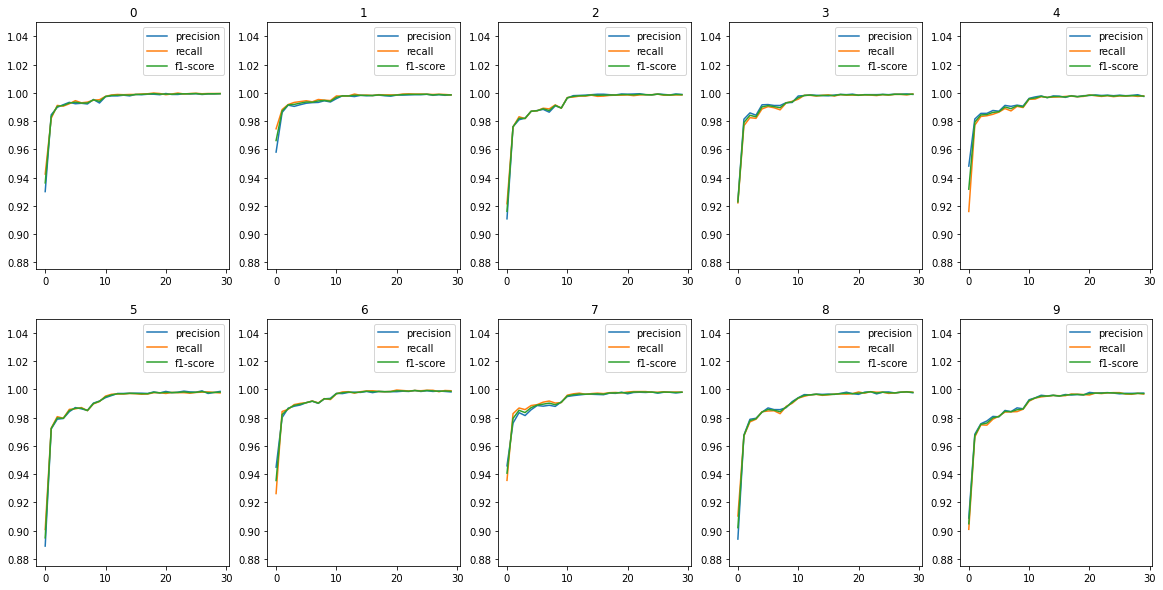

In [43]:
log_df = pd.read_json(log_file)['train'].apply(pd.Series)
dfs = [log_df['report_label'].apply(pd.Series)[f'{cls_idx}'].apply(pd.Series) for cls_idx in range(10)]
r = 2
plt.figure(figsize=(20, 10))
for i, df in enumerate(dfs):
    ax = plt.subplot(r, len(dfs) // r, i + 1)
    ax.set_ylim([0.875, 1.05])
    ax.set_title(i)
    df[['precision', 'recall', 'f1-score']].plot(ax=ax)

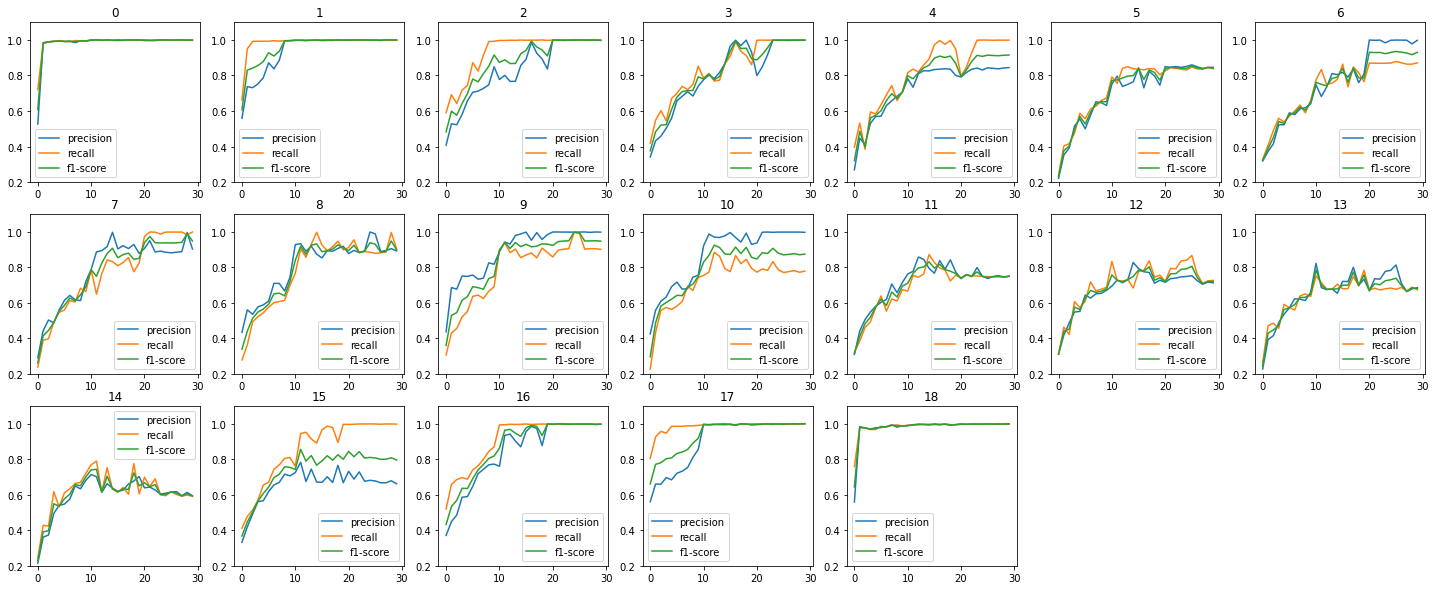

In [50]:
log_df = pd.read_json(log_file)['train'].apply(pd.Series)
dfs = [log_df['report_out_num'].apply(pd.Series)[f'{cls_idx}'].apply(pd.Series) for cls_idx in range(19)]
r = 3
plt.figure(figsize=(25, 10))
for i, df in enumerate(dfs):
    ax = plt.subplot(r, 1 + (len(dfs) // r), i + 1)
    ax.set_ylim([0.2, 1.1])
    ax.set_title(i)
    df[['precision', 'recall', 'f1-score']].plot(ax=ax)

## Testing metrics (precision, recall and f1-score)

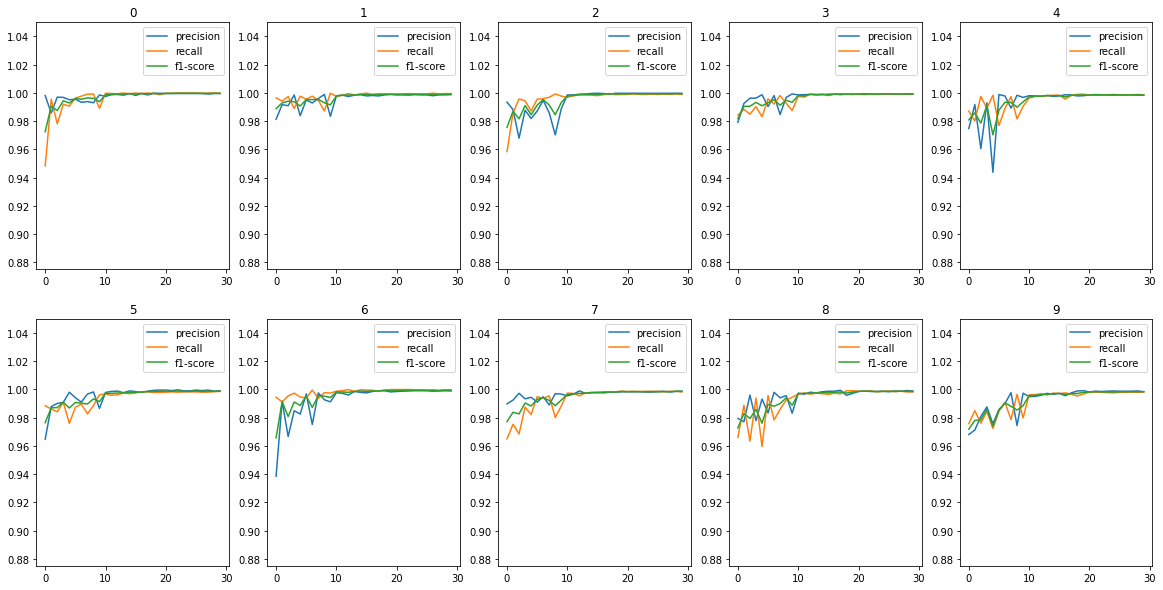

In [64]:
log_df = pd.read_json(log_file)['test'].apply(pd.Series)
dfs = [log_df['report_label'].apply(pd.Series)[f'{cls_idx}'].apply(pd.Series) for cls_idx in range(10)]
r = 2
plt.figure(figsize=(20, 10))
for i, df in enumerate(dfs):
    ax = plt.subplot(r, len(dfs) // r, i + 1)
    ax.set_ylim([0.875, 1.05])
    ax.set_title(i)
    df[['precision', 'recall', 'f1-score']].plot(ax=ax)

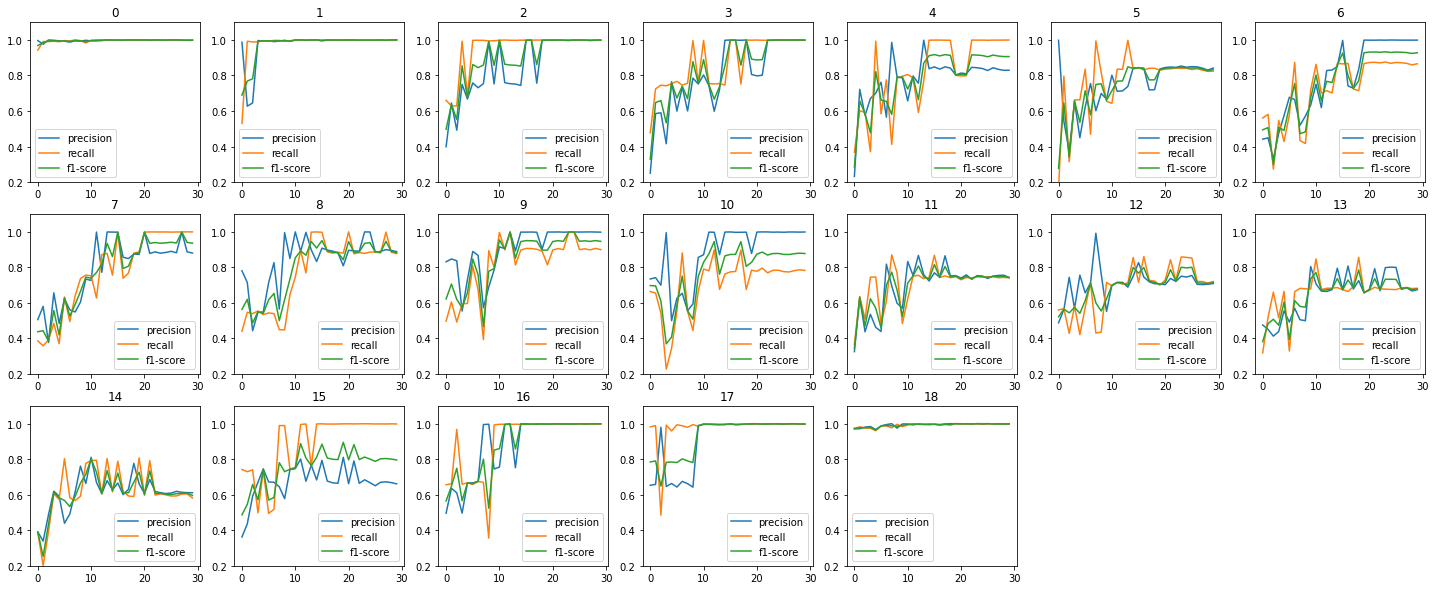

In [65]:
log_df = pd.read_json(log_file)['test'].apply(pd.Series)
dfs = [log_df['report_out_num'].apply(pd.Series)[f'{cls_idx}'].apply(pd.Series) for cls_idx in range(19)]
r = 3
plt.figure(figsize=(25, 10))
for i, df in enumerate(dfs):
    ax = plt.subplot(r, 1 + (len(dfs) // r), i + 1)
    ax.set_ylim([0.2, 1.1])
    ax.set_title(i)
    df[['precision', 'recall', 'f1-score']].plot(ax=ax)

## Loss plot

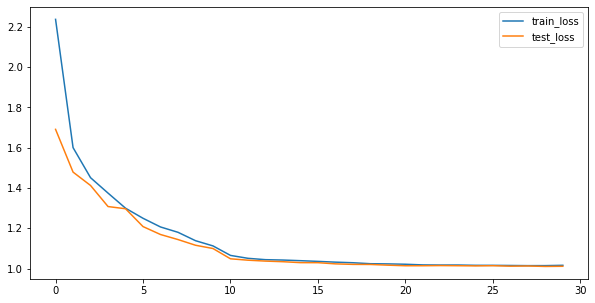

In [62]:
fig = plt.figure(figsize=(10, 5))

log_df = pd.read_json(log_file)['train'].apply(pd.Series)
log_df['train_loss'].plot(fig=fig, legend=True)

log_df = pd.read_json(log_file)['test'].apply(pd.Series)
log_df['test_loss'].plot(fig=fig, legend=True)